# Overview
The goal of the module, or at least this assignment, is to show them the
relationship between currency alternates, currency stores, economic outook instruments,
interest rates, and government action instruments. This done through the following:

    Currency Alternate: Bitcoin
    Currency Store/Sink: Gold
    Economic Outlook/Interest Rates: Bond ETF
    Government Action Intstrument: MBS ETF
    
On top of all the quantitative analysis, they should be able to both inherently
and quantitatively understand and delineate the relationships and how they influence 
both the economy and the financial markets.

In [1]:
import yfinance as yf
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import statistics as st
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from talib import NATR
from talib import ATR
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
def import_tickers(tickers=str, start=str, end=str):
    '''
    This function imports your desired list of tickers in the form of a string:
        't1 t2 t3...'
    It then cleans the individual dataframes and formats them into a list.
    Finally, it combines the dataframes by merging them on 'Date'
    '''
    def cleaning_tickers(tickers=list):
        #This subfunction cleans the ticker string and outputs a list of tickers.
        punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
        tickers = tickers.lower().replace(' ', '|')
        for character in tickers:
            if character in punctuations:
                tickers = tickers.replace(character, '')
        tickers = tickers.upper()
        ticker = ''
        filtered = []
        for character in tickers:
            if character != '|':
                ticker = ticker + character
            else:
                filtered.append(ticker)
                ticker = ''
        filtered.append(ticker)
        return filtered
    
    def import_data(ticker=str, start=str, end=str):
        '''
        This subfunction imports the data and performs a few cleaning methods on it,
        including losing NaN rows, resetting the index to a range instead of Date,
        and identifying the relevant columns.
        Returns the cleaned dataframe.
        '''
        ticker = ticker.upper()
        df = yf.download(ticker, start, end, progress=False)
        df = df.dropna()
        df['Date'] = df.index
        df.index = range(0, len(list(df.index)))
        df = df[['Date', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]
        df = df.rename(columns={'Date': 'Date',
                                'High': str(ticker+'_High'),
                                'Low': str(ticker+'_Low'),
                                'Close': str(ticker+'_Close'),
                                'Volume': str(ticker+'_Volume'),
                                'Adj Close': str(ticker+'_Adj_Close')})
        return df

    def combine_dfs(dfs=list):
        '''
        This subfunction merges the newly imported ticker dataframes into one usable
        dataframe, and outputs the combined df.
        '''
        dates = [date for date in dfs[0].Date]
        combined = pd.DataFrame()
        for n, df in enumerate(dfs):
            if n == (len(dfs)-1):
                break
            if (n == 0):
                combined = pd.merge(dfs[n], dfs[n+1], on='Date')
            if (n > 0):
                combined = pd.merge(combined, dfs[n+1], on='Date')
        return combined

    # Performing the function calls defined above
    tickers = cleaning_tickers(tickers)
    dataframes = []
    for n, ticker in enumerate(tickers):
        dataframes.append(import_data(ticker, start, end))
    return combine_dfs(dataframes)

In [3]:
# String of tickers
'''
ICVT - iShares Convertible Bond Market
BTC=F - CME Bitcoin Futures
VMBS - Vanguard Mortgage-Backed Securities Fund
GLD - SPDR Gold Trust
'''
tickers_str = 'ICVT BTC=F VMBS GLD'
# List of tickers
tickers = ['ICVT', 'BTC=F', 'VMBS', 'GLD']
data = import_tickers(tickers_str, '2017-01-01', '2021-10-15')
data

,Date,ICVT_High,ICVT_Low,ICVT_Close,ICVT_Volume,ICVT_Adj_Close,BTC=F_High,BTC=F_Low,BTC=F_Close,BTC=F_Volume,...,VMBS_High,VMBS_Low,VMBS_Close,VMBS_Volume,VMBS_Adj_Close,GLD_High,GLD_Low,GLD_Close,GLD_Volume,GLD_Adj_Close
0,2017-12-18,55.639999,55.365002,55.610001,7300,49.368862,20650.0,18345.0,19100.0,1054,...,52.619999,52.549999,52.580002,387900,48.303547,119.989998,119.599998,119.730003,5452200,119.730003
1,2017-12-19,55.630001,55.361000,55.436001,7100,49.214386,19725.0,17180.0,18200.0,559,...,52.560001,52.430000,52.439999,510800,48.174923,119.900002,119.529999,119.820000,4018900,119.820000
2,2017-12-20,55.730000,55.590000,55.689999,19900,49.439880,18350.0,16435.0,17040.0,784,...,52.419998,52.369999,52.380001,480600,48.119816,120.360001,119.809998,120.139999,5734600,120.139999
3,2017-12-21,55.650002,55.354000,55.509998,9800,49.469296,17270.0,15080.0,15330.0,879,...,52.400002,52.349998,52.389999,347200,48.128998,120.449997,120.000000,120.309998,4823700,120.309998
4,2017-12-22,55.430000,55.278999,55.345001,3100,49.322247,15825.0,12265.0,14135.0,2374,...,52.430000,52.369999,52.389999,368200,48.128998,121.139999,120.570000,120.940002,5791300,120.940002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,2021-10-08,101.330002,100.290001,100.300003,105100,100.300003,56815.0,54155.0,55180.0,5063,...,53.200001,53.090000,53.099998,963500,53.099998,166.419998,164.139999,164.229996,8535500,164.229996
951,2021-10-11,100.669998,99.748001,99.830002,168600,99.830002,58355.0,54820.0,57990.0,5686,...,53.090000,53.029999,53.029999,735100,53.029999,164.580002,163.910004,163.919998,3820100,163.919998
952,2021-10-12,100.930000,99.980003,100.550003,317000,100.550003,58215.0,54370.0,55815.0,6691,...,53.080002,53.000000,53.070000,514000,53.070000,165.440002,164.309998,164.660004,5453000,164.660004
953,2021-10-13,101.419998,100.660004,101.419998,167900,101.419998,57950.0,54700.0,57750.0,6939,...,53.150002,53.060001,53.150002,1144600,53.150002,167.919998,165.279999,167.589996,11113800,167.589996


/Users/siddharth/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


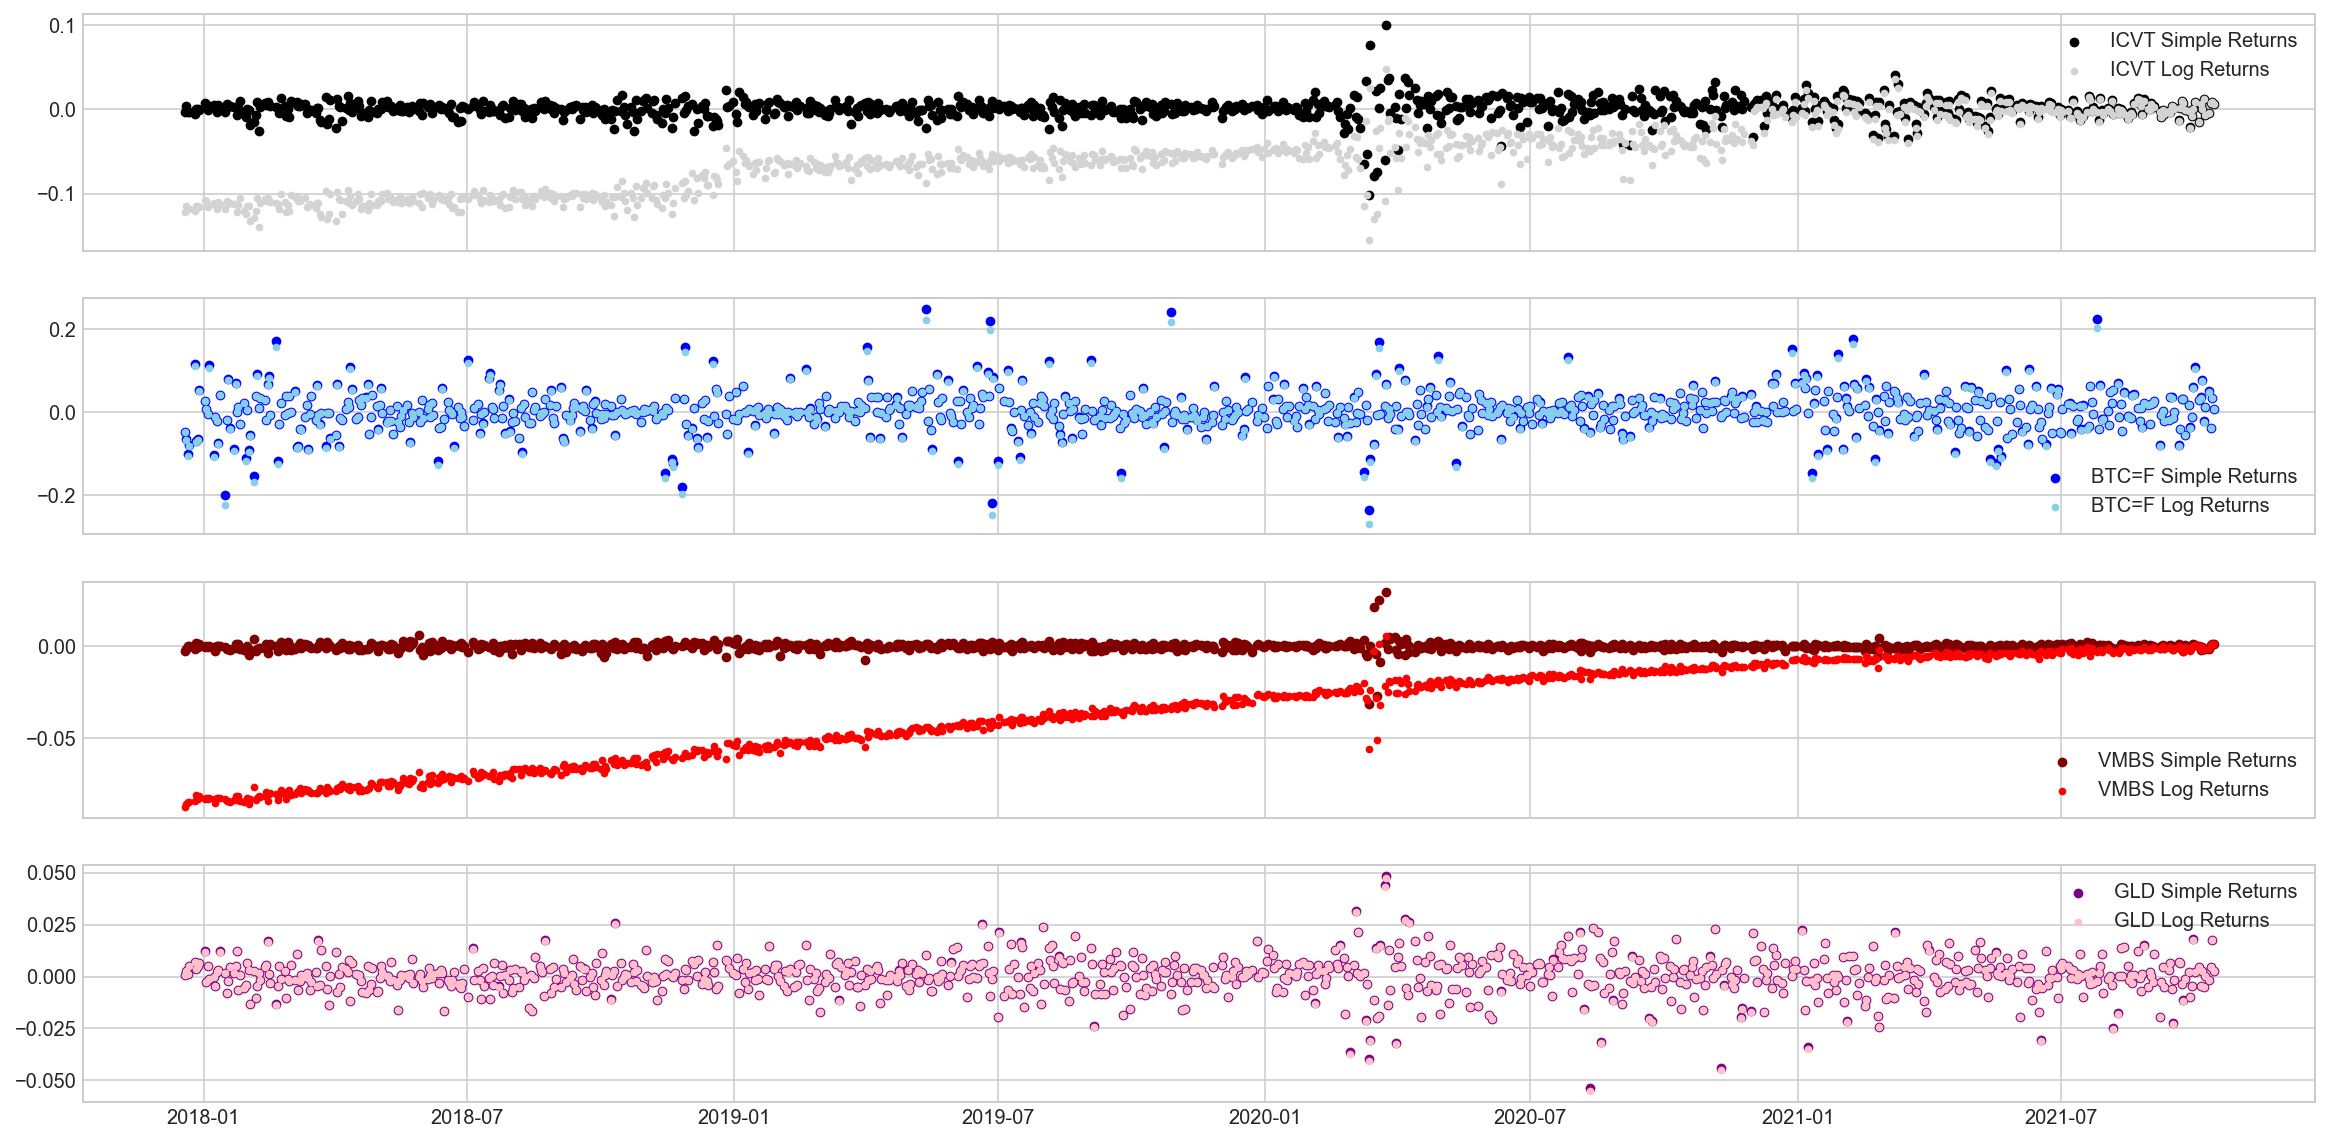

In [4]:
# Calculating simple and log returns for each security
for n, ticker in enumerate(tickers):
    data[ticker+'_Simple_Return'] = data[ticker+'_Close'].pct_change()
    data[ticker+'_Log_Return'] = np.log(data[ticker+'_Adj_Close']/data[ticker+'_Close'].shift(1))
data.tail()

# Plotting simple and log returns
for n, ticker in enumerate(tickers):
    fig, ax = plt.subplots(nrows=4,ncols=1, figsize=(20, 10), sharex=True)
    ax[0,].scatter(data.Date, data[ticker+'_Simple_Return'], label=str(ticker+' Simple Returns'), color='black', s=15)
    ax[0,].scatter(data.Date, data[ticker+'_Log_Return'], label=str(ticker+' Log Returns'), color='lightgrey', s=8)
    ax[0,].legend()
    ax[1,].scatter(data.Date, data[tickers[n+1]+'_Simple_Return'], label=str(tickers[n+1]+' Simple Returns'), color='blue', s=15)
    ax[1,].scatter(data.Date, data[tickers[n+1]+'_Log_Return'], label=str(tickers[n+1]+' Log Returns'), color='skyblue', s=8)
    ax[1,].legend()
    ax[2,].scatter(data.Date, data[tickers[n+2]+'_Simple_Return'], label=str(tickers[n+2]+' Simple Returns'), color='maroon', s=15)
    ax[2,].scatter(data.Date, data[tickers[n+2]+'_Log_Return'], label=str(tickers[n+2]+' Log Returns'), color='red', s=8)
    ax[2,].legend()
    ax[3,].scatter(data.Date, data[tickers[n+3]+'_Simple_Return'], label=str(tickers[n+3]+' Simple Returns'), color='purple', s=15)
    ax[3,].scatter(data.Date, data[tickers[n+3]+'_Log_Return'], label=str(tickers[n+3]+' Log Returns'), color='pink', s=8)
    ax[3,].legend()
    break

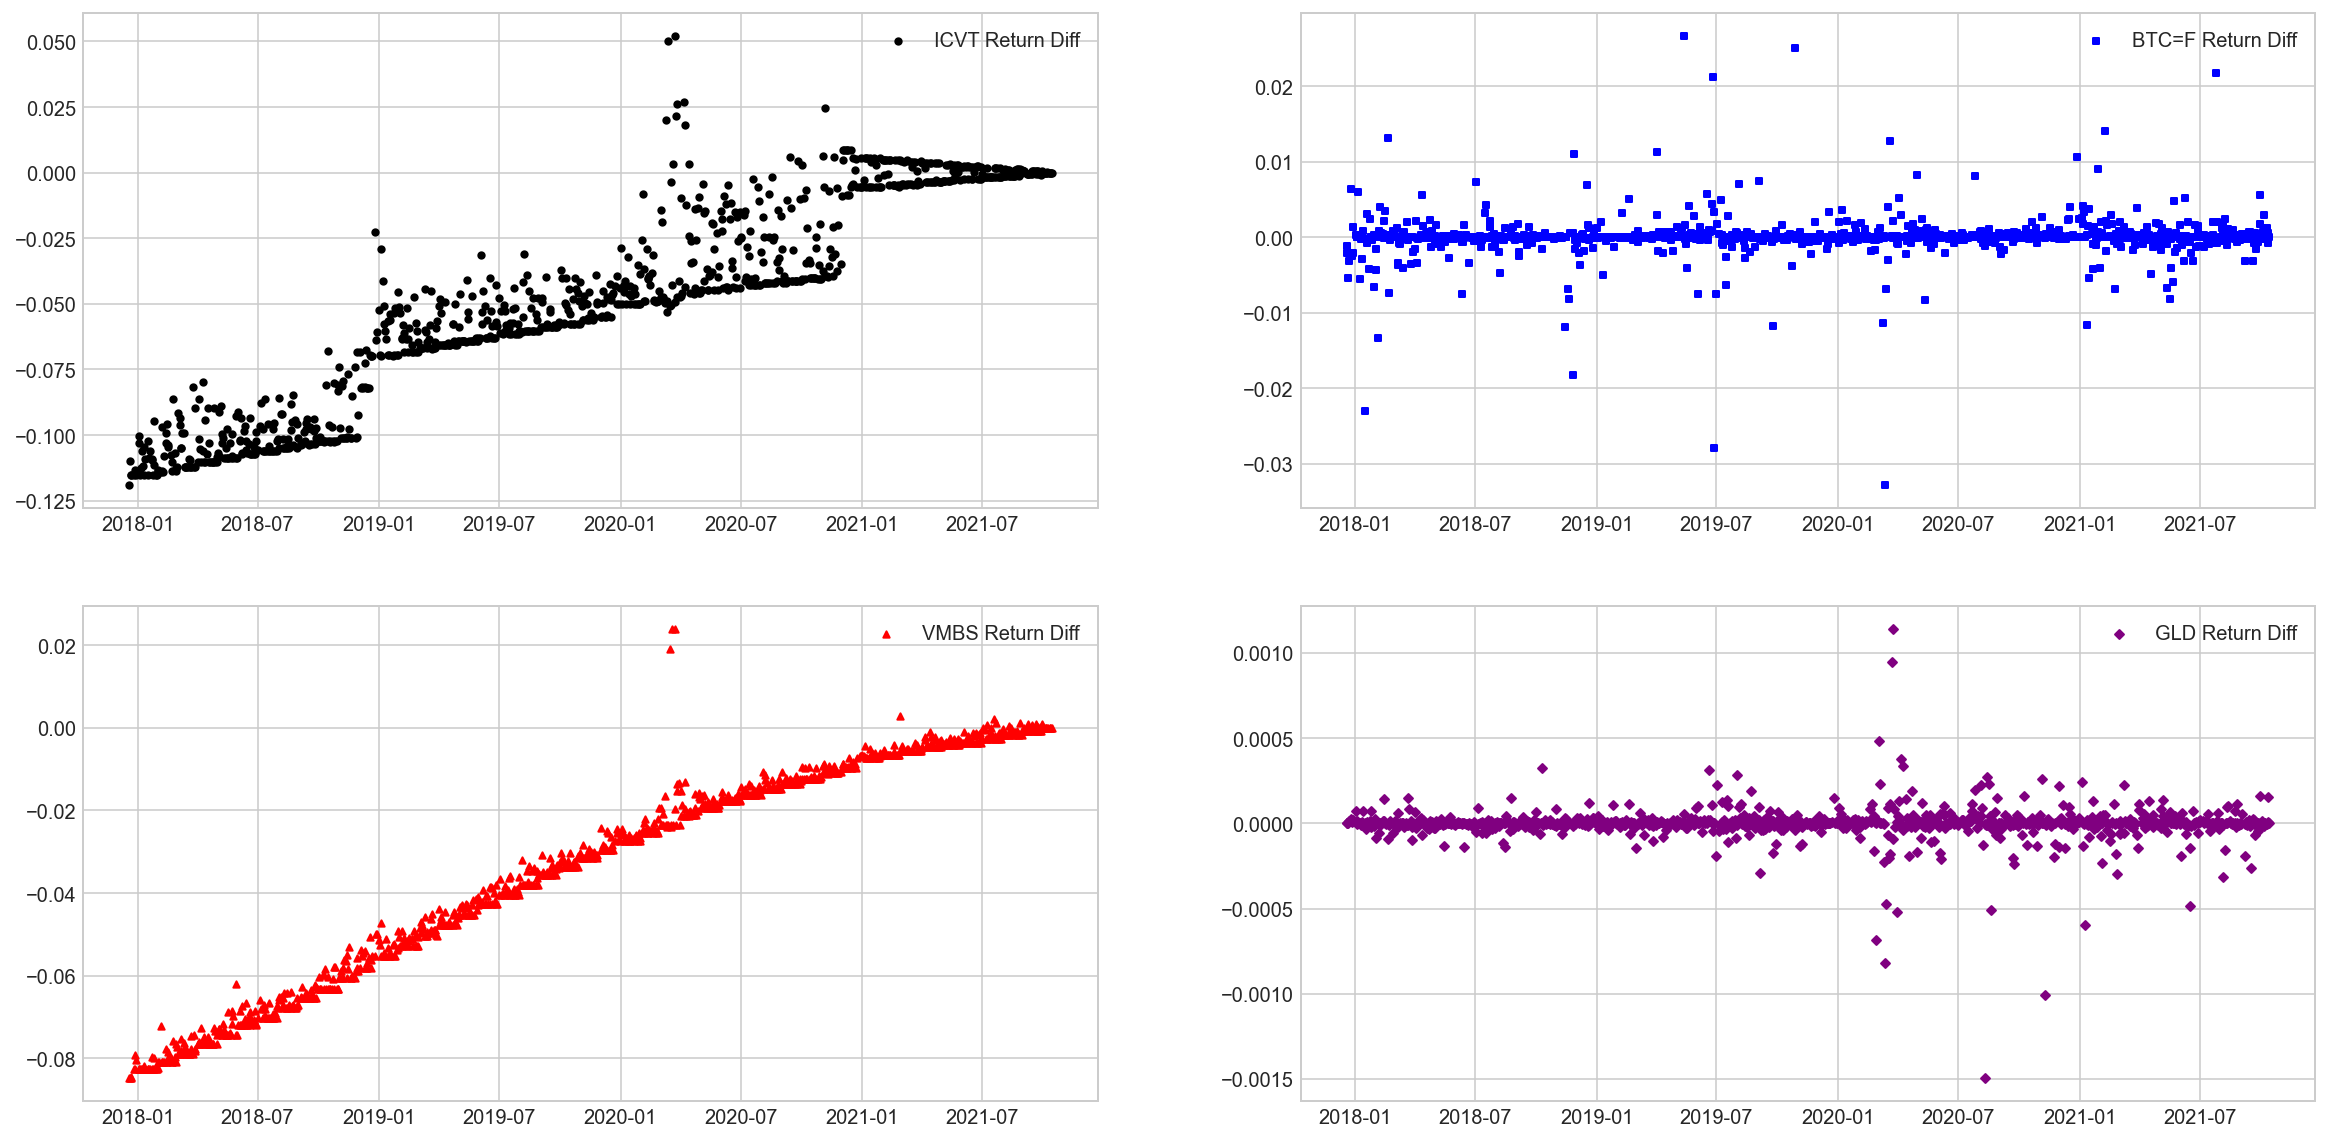

In [5]:
# Finding the difference in the returns
for n, ticker in enumerate(tickers):
    data[ticker+'_Return_Diff'] = [resid for resid in abs(data[ticker+'_Simple_Return'])-abs(data[ticker+'_Log_Return'])]

# Plotting the difference in returns
for n, ticker in enumerate(tickers):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
    axes[0,0].scatter(data.Date, data[ticker+'_Return_Diff'], label=str(ticker+' Return Diff'), color='black', s=10)
    axes[0,0].legend()
    axes[0,1].scatter(data.Date, data[tickers[n+1]+'_Return_Diff'], label=str(tickers[n+1]+' Return Diff'), color='blue', marker='s', s=10)
    axes[0,1].legend()
    axes[1,0].scatter(data.Date, data[tickers[n+2]+'_Return_Diff'], label=str(tickers[n+2]+' Return Diff'), color='red', marker='^', s=10)
    axes[1,0].legend()
    axes[1,1].scatter(data.Date, data[tickers[n+3]+'_Return_Diff'], label=str(tickers[n+3]+' Return Diff'), color='purple', marker='D', s=10)
    axes[1,1].legend()
    break

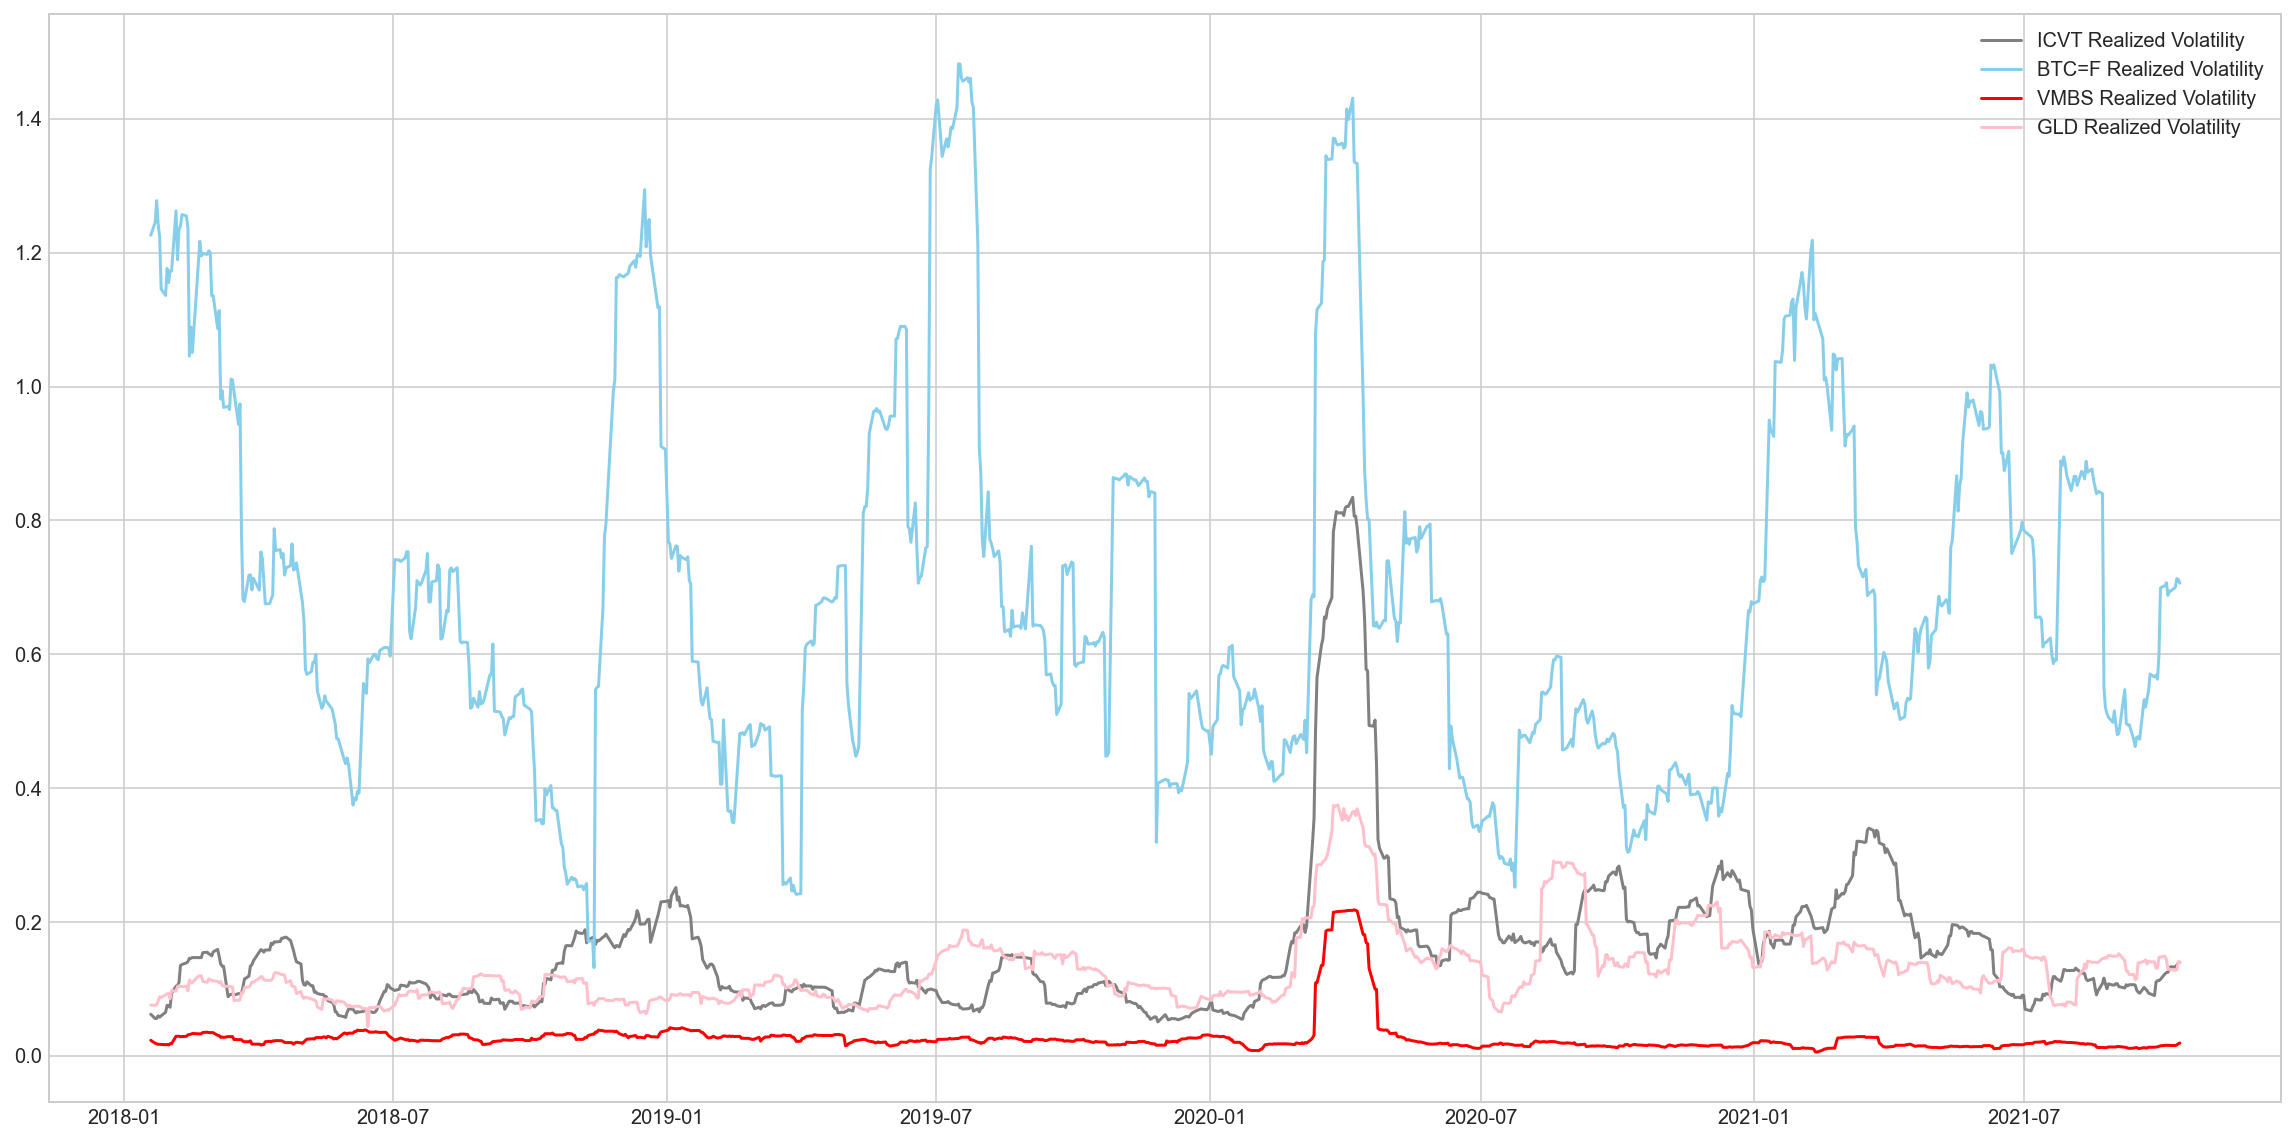

In [6]:
# Finding the realized volatility
for n, ticker in enumerate(tickers):
    data[ticker+'_Real_Vol'] = data[ticker+'_Log_Return'].rolling(window=21).std(ddof=0)*np.sqrt(252)
data.tail()

# Plotting realized volatility
for n, ticker in enumerate(tickers):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(data.Date, data[ticker+'_Real_Vol'], label=str(ticker+' Realized Volatility'), color='grey')
    ax.plot(data.Date, data[tickers[n+1]+'_Real_Vol'], label=str(tickers[n+1]+' Realized Volatility'), color='skyblue')
    ax.plot(data.Date, data[tickers[n+2]+'_Real_Vol'], label=str(tickers[n+2]+' Realized Volatility'), color='red')
    ax.plot(data.Date, data[tickers[n+3]+'_Real_Vol'], label=str(tickers[n+3]+' Realized Volatility'), color='pink')
    ax.legend()
    break

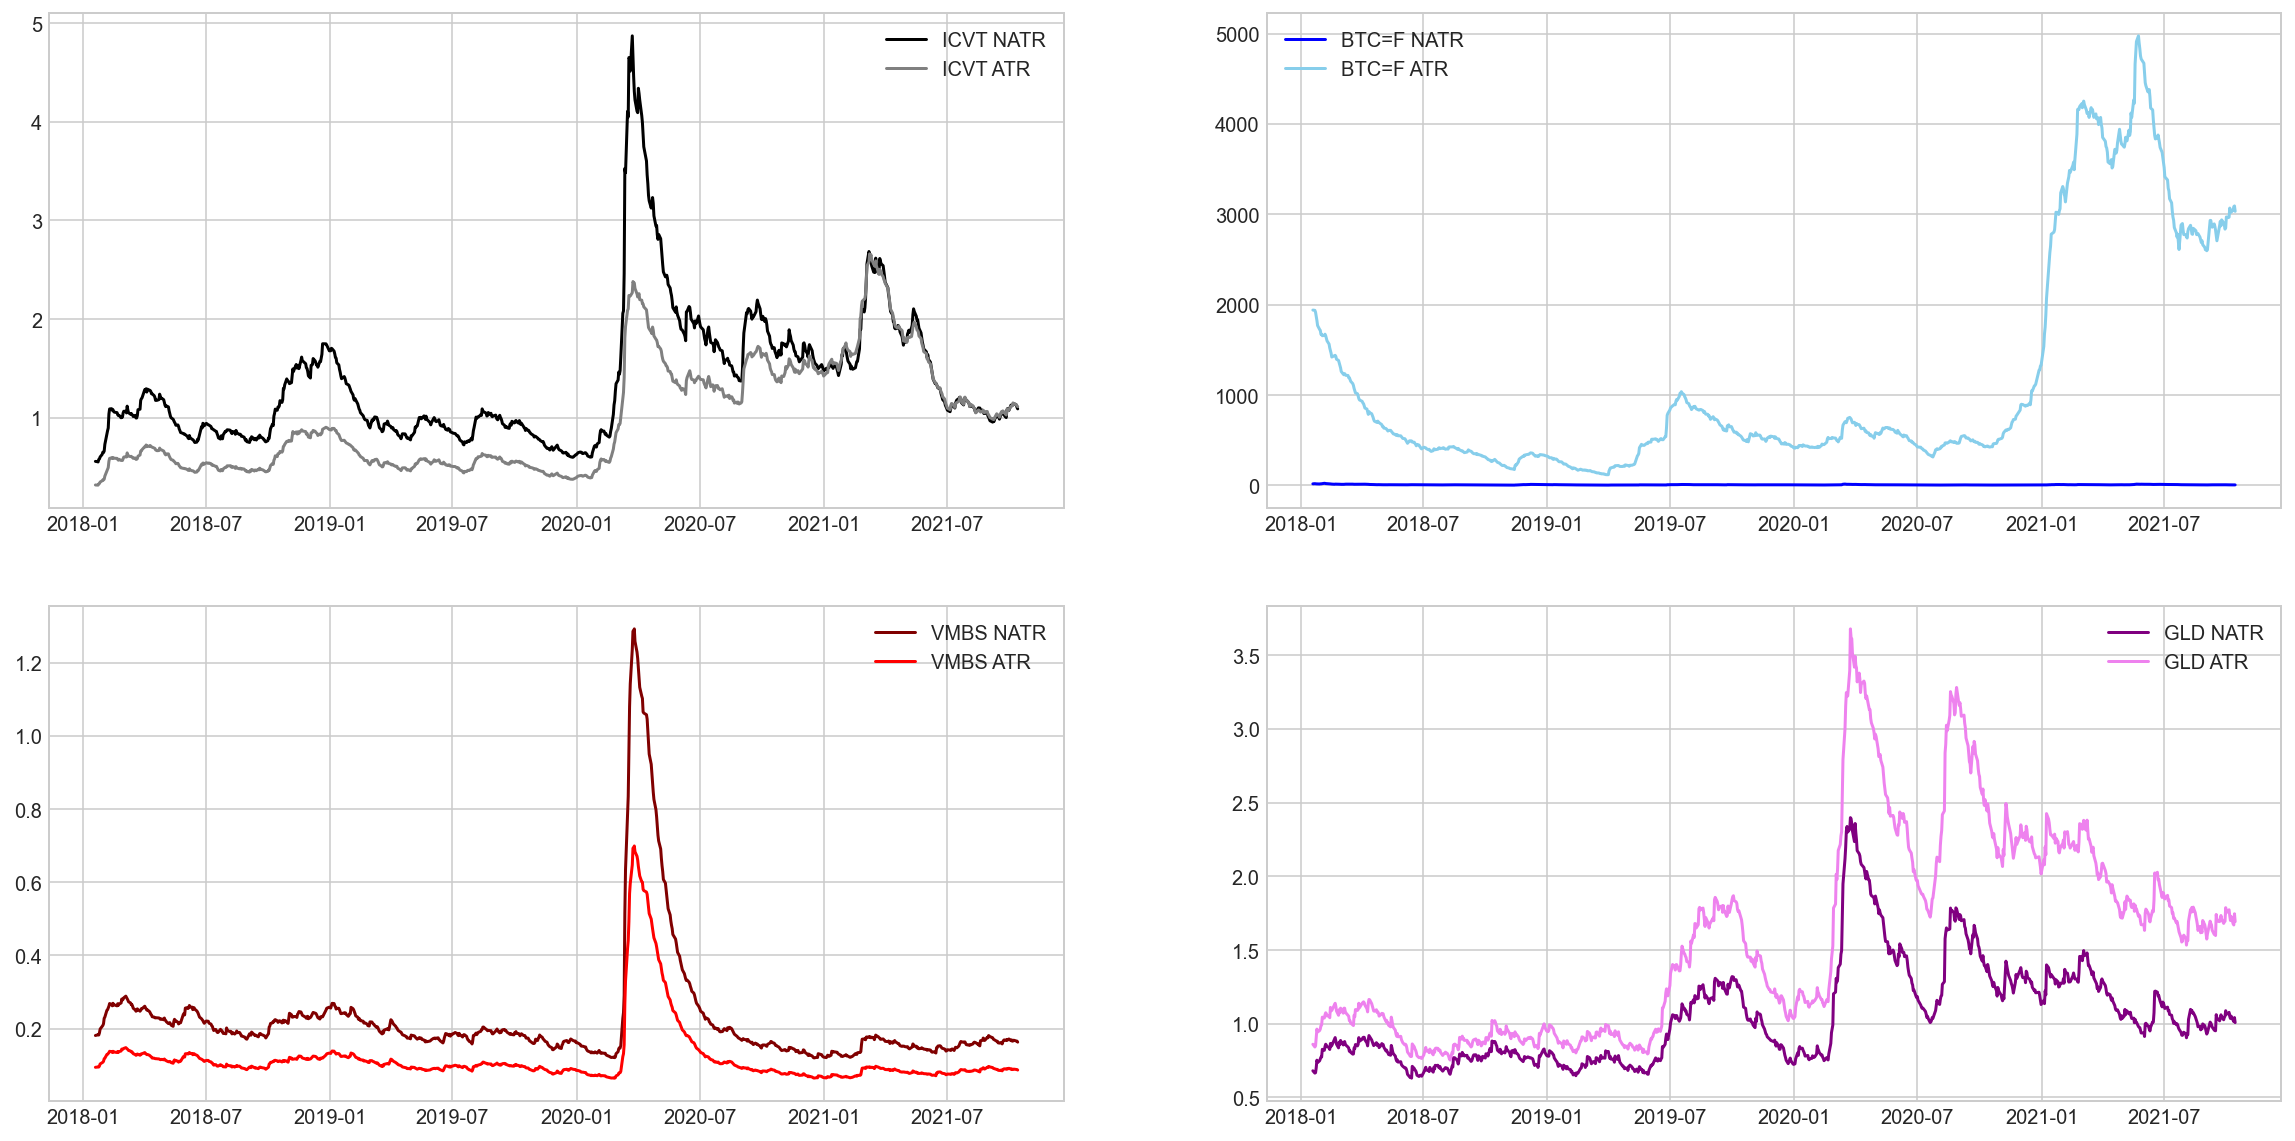

In [7]:
# Calculating Average True Range and Normalized ATR
for n, ticker in enumerate(tickers):
    data[ticker+'_NATR'] = list(NATR(data[ticker+'_High'], data[ticker+'_Low'], data[ticker+'_Close'], timeperiod=21))
    data[ticker+'_ATR'] = list(ATR(data[ticker+'_High'], data[ticker+'_Low'], data[ticker+'_Close'], timeperiod=21))

# Plotting the Average True Range and Normalized ATR
for n, ticker in enumerate(tickers):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
    axes[0,0].plot(data.Date, data[ticker+'_NATR'], label=str(ticker+' NATR'), color='black')
    axes[0,0].plot(data.Date, data[ticker+'_ATR'], label=str(ticker+' ATR'), color='grey')
    axes[0,0].legend()
    axes[0,1].plot(data.Date, data[tickers[n+1]+'_NATR'], label=str(tickers[n+1]+' NATR'), color='blue')
    axes[0,1].plot(data.Date, data[tickers[n+1]+'_ATR'], label=str(tickers[n+1]+' ATR'), color='skyblue')
    axes[0,1].legend()
    axes[1,0].plot(data.Date, data[tickers[n+2]+'_NATR'], label=str(tickers[n+2]+' NATR'), color='maroon')
    axes[1,0].plot(data.Date, data[tickers[n+2]+'_ATR'], label=str(tickers[n+2]+' ATR'), color='red')
    axes[1,0].legend()
    axes[1,1].plot(data.Date, data[tickers[n+3]+'_NATR'], label=str(tickers[n+3]+' NATR'), color='purple')
    axes[1,1].plot(data.Date, data[tickers[n+3]+'_ATR'], label=str(tickers[n+3]+' ATR'), color='violet')
    axes[1,1].legend()
    break

In [8]:
# Creating a separate dataframe with the original, unscaled close prices
close_df = data[['ICVT_Close', 'BTC=F_Close', 'VMBS_Close', 'GLD_Close',
                 'ICVT_Adj_Close', 'BTC=F_Adj_Close', 'VMBS_Adj_Close', 'GLD_Adj_Close',
                 'ICVT_Volume', 'BTC=F_Volume', 'VMBS_Volume', 'GLD_Volume']]
#close_df[scale_vars] = StandardScaler().fit_transform(close_df[scale_vars])

# Scaling the close prices into min/max for charting
scale_vars = ['ICVT_Close', 'BTC=F_Close', 'VMBS_Close', 'GLD_Close']
data[scale_vars] = MinMaxScaler().fit_transform(data[scale_vars])
data.tail()

,Date,ICVT_High,ICVT_Low,ICVT_Close,ICVT_Volume,ICVT_Adj_Close,BTC=F_High,BTC=F_Low,BTC=F_Close,BTC=F_Volume,...,VMBS_Real_Vol,GLD_Real_Vol,ICVT_NATR,ICVT_ATR,BTC=F_NATR,BTC=F_ATR,VMBS_NATR,VMBS_ATR,GLD_NATR,GLD_ATR
950,2021-10-08,101.330002,100.290001,0.846033,105100,100.300003,56815.0,54155.0,0.857319,5063,...,0.015679,0.128758,1.142478,1.145905,5.476480,3021.921781,0.168294,0.089364,1.052137,1.727924
951,2021-10-11,100.669998,99.748001,0.838634,168600,99.830002,58355.0,54820.0,0.903616,5686,...,0.015576,0.128024,1.137176,1.135243,5.253240,3046.354077,0.166778,0.088442,1.023393,1.677546
952,2021-10-12,100.930000,99.980003,0.849969,317000,100.550003,58215.0,54370.0,0.867782,6691,...,0.016556,0.128549,1.127364,1.133565,5.526086,3084.384835,0.165895,0.088040,1.014238,1.670044
953,2021-10-13,101.419998,100.660004,0.863665,167900,101.419998,57950.0,54700.0,0.899662,6939,...,0.018226,0.141171,1.105318,1.121014,5.354582,3092.271272,0.165821,0.088134,1.041683,1.745756
954,2021-10-14,102.379997,101.974998,0.873740,300000,102.059998,59025.0,57190.0,0.906994,6318,...,0.019331,0.140056,1.090874,1.113346,5.210759,3032.401211,0.163116,0.086794,1.007515,1.692625


In [9]:
'''
Finding the elasticity and sensitivity of the prices in relation to volume,
realized volatility, ATR, and NATR
Note the formulas below:
    Elasticity:   ε = %ΔP/%ΔV
    Sensitivity:  η = %ΔP/$Δσ
'''
elasticity_df = close_df.copy(deep=True) # Copying the original close prices
elasticity_df = elasticity_df.pct_change(fill_method='ffill') # Finding the percent change
# Calculating elasticity/sensitivity for each security
for n, ticker in enumerate(tickers):
    elasticity_df[ticker+'_Elasticity'] = elasticity_df[ticker+'_Close']/elasticity_df[ticker+'_Volume']
    elasticity_df[ticker+'_Sensitivity'] = elasticity_df[ticker+'_Close']/data[ticker+'_Real_Vol']
    elasticity_df[ticker+'_ATR%'] = elasticity_df[ticker+'_Close']/data[ticker+'_ATR']
    elasticity_df[ticker+'_NATR%'] = elasticity_df[ticker+'_Close']/data[ticker+'_NATR']
    elasticity_df[ticker+'_Close'] = close_df[ticker+'_Close']
    elasticity_df[ticker+'_Adj_Close'] = close_df[ticker+'_Adj_Close']
# Adding a date column, dropping rows with NaN, filliing any remaining NaN values
elasticity_df['Date'] = data.Date 
elasticity_df = elasticity_df.dropna() 
elasticity_df = elasticity_df.fillna(method='ffill') 

# Reducing extraneous elasticities to normal values
for n, ticker in enumerate(tickers):
    temp = [val for val in elasticity_df[ticker+'_Elasticity']]
    for m, value in enumerate(temp):
        if float(value) > 3:
            temp[m] = 3
        elif float(value) < -3:
            temp[m] = -3
    elasticity_df[ticker+'_Elasticity'] = temp
elasticity_df.tail()

,ICVT_Close,BTC=F_Close,VMBS_Close,GLD_Close,ICVT_Adj_Close,BTC=F_Adj_Close,VMBS_Adj_Close,GLD_Adj_Close,ICVT_Volume,BTC=F_Volume,...,BTC=F_NATR%,VMBS_Elasticity,VMBS_Sensitivity,VMBS_ATR%,VMBS_NATR%,GLD_Elasticity,GLD_Sensitivity,GLD_ATR%,GLD_NATR%,Date
950,100.300003,55180.0,53.099998,164.229996,100.300003,55180.0,53.099998,164.229996,-0.225497,-0.048845,...,0.002380,-0.029270,-0.095948,-0.016834,-0.008939,0.000546,0.003311,0.000247,0.000405,2021-10-08
951,99.830002,57990.0,53.029999,163.919998,99.830002,57990.0,53.029999,163.919998,0.604186,0.123050,...,0.009694,0.005561,-0.084632,-0.014905,-0.007904,0.003417,-0.014744,-0.001125,-0.001844,2021-10-11
952,100.550003,55815.0,53.070000,164.660004,100.550003,55815.0,53.070000,164.660004,0.880190,0.176750,...,-0.006787,-0.002508,0.045560,0.008568,0.004547,0.010561,0.035118,0.002703,0.004451,2021-10-12
953,101.419998,57750.0,53.150002,167.589996,101.419998,57750.0,53.150002,167.589996,-0.470347,0.037065,...,0.006474,0.001229,0.082710,0.017104,0.009091,0.017141,0.126047,0.010193,0.017082,2021-10-13
954,102.059998,58195.0,53.209999,168.000000,102.059998,58195.0,53.209999,168.000000,0.786778,-0.089494,...,0.001479,-0.008637,0.058396,0.013006,0.006920,-0.004507,0.017468,0.001445,0.002428,2021-10-14


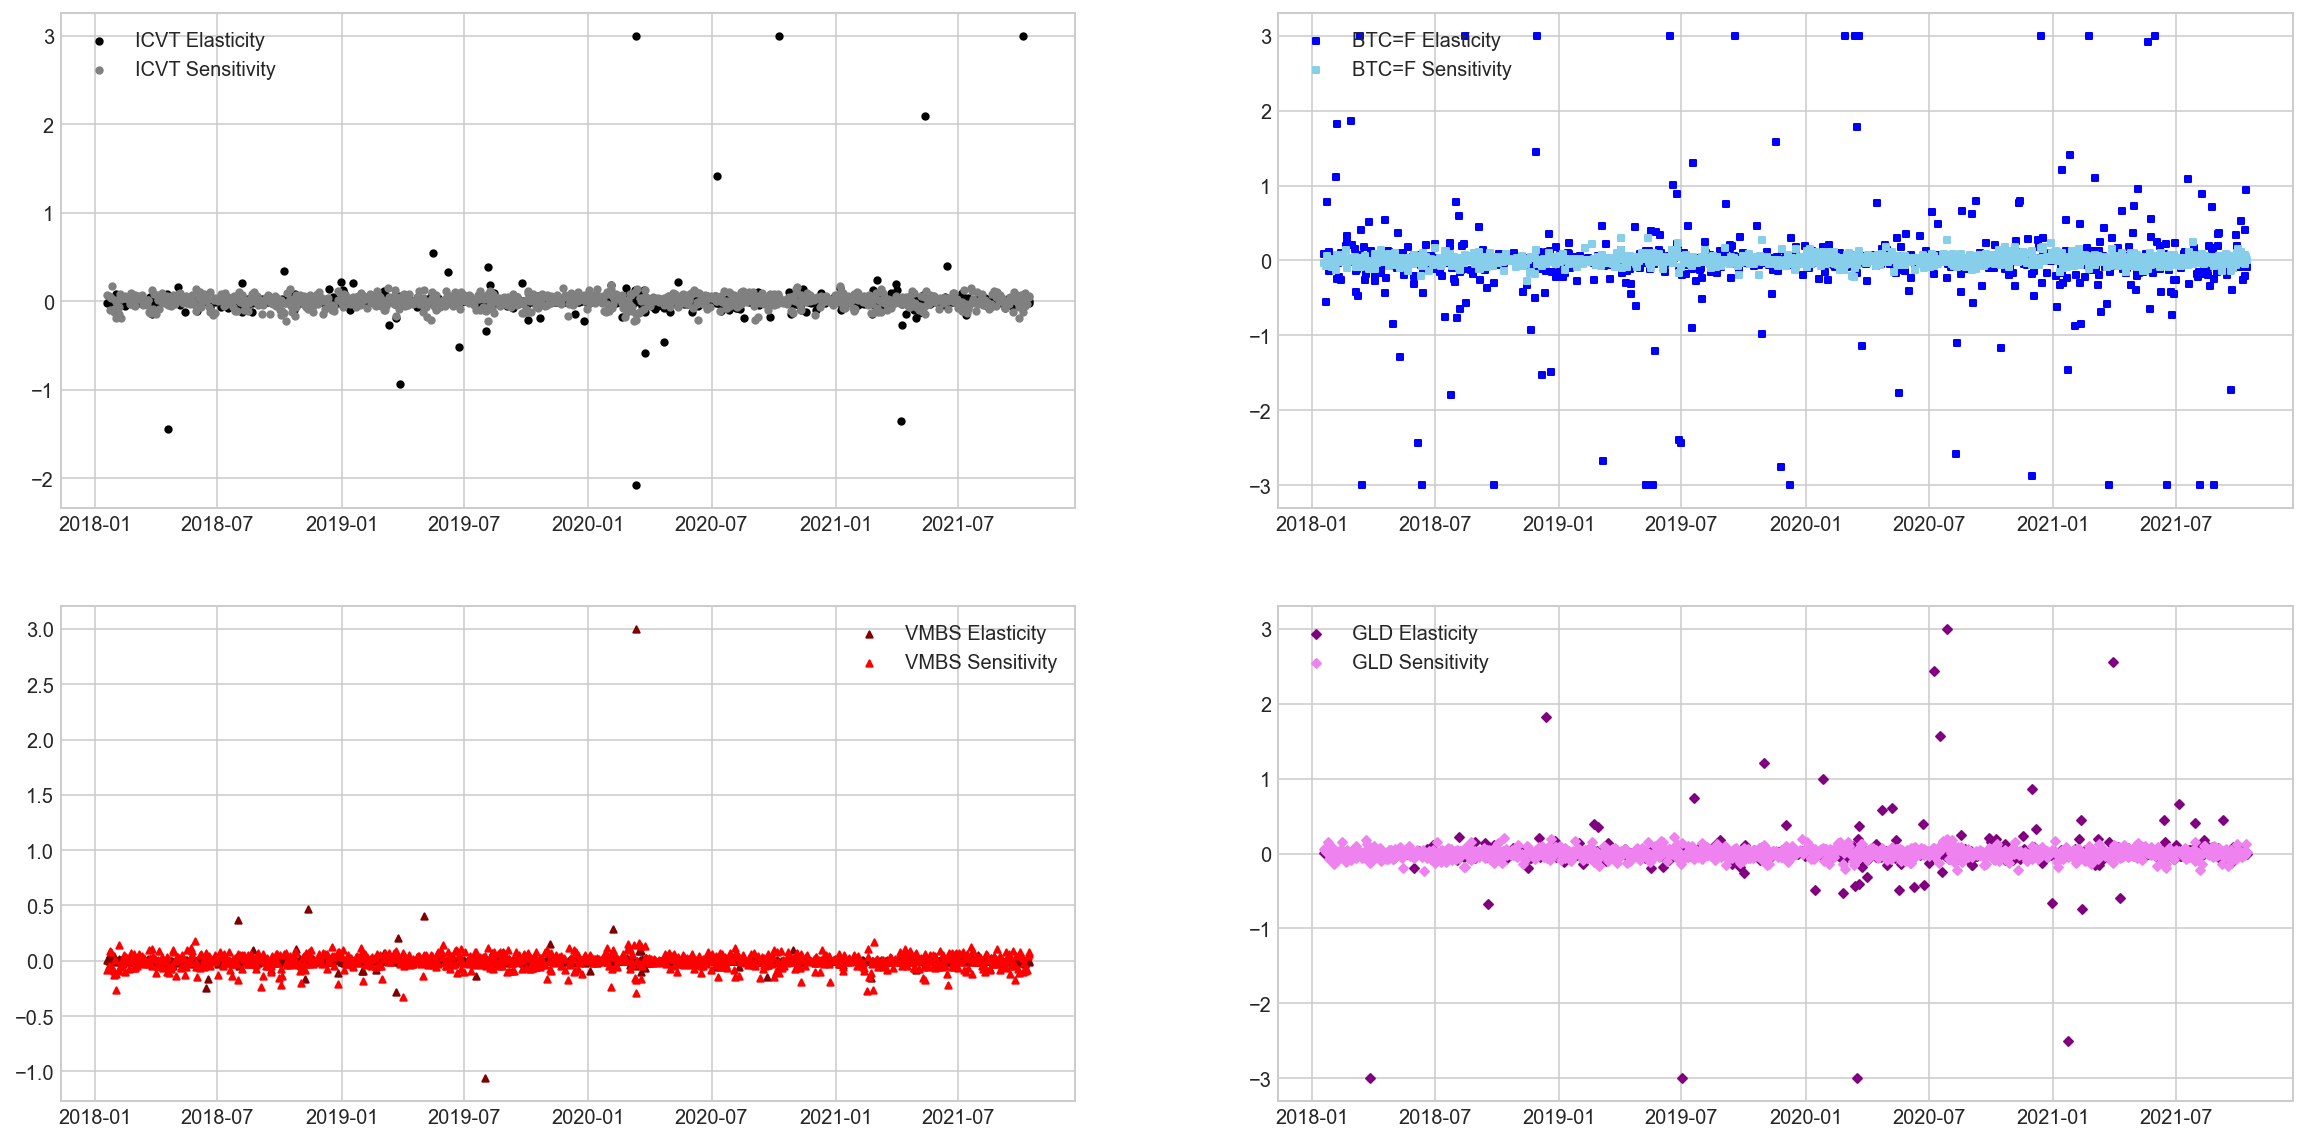

In [10]:
#Plotting the elasticities 
for n, ticker in enumerate(tickers):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
    axes[0,0].scatter(elasticity_df.Date, elasticity_df[ticker+'_Elasticity'], label=str(ticker+' Elasticity'), color='black', s=10)
    axes[0,0].scatter(elasticity_df.Date, elasticity_df[ticker+'_Sensitivity'], label=str(ticker+' Sensitivity'), color='grey', s=10)
    axes[0,0].legend()
    axes[0,1].scatter(elasticity_df.Date, elasticity_df[tickers[n+1]+'_Elasticity'], label=str(tickers[n+1]+' Elasticity'), color='blue', marker='s', s=10)
    axes[0,1].scatter(elasticity_df.Date, elasticity_df[tickers[n+1]+'_Sensitivity'], label=str(tickers[n+1]+' Sensitivity'), color='skyblue', marker='s', s=10)
    axes[0,1].legend()
    axes[1,0].scatter(elasticity_df.Date, elasticity_df[tickers[n+2]+'_Elasticity'], label=str(tickers[n+2]+' Elasticity'), color='maroon', marker='^', s=10)
    axes[1,0].scatter(elasticity_df.Date, elasticity_df[tickers[n+2]+'_Sensitivity'], label=str(tickers[n+2]+' Sensitivity'), color='red', marker='^', s=10)
    axes[1,0].legend()
    axes[1,1].scatter(elasticity_df.Date, elasticity_df[tickers[n+3]+'_Elasticity'], label=str(tickers[n+3]+' Elasticity'), color='purple', marker='D', s=10)
    axes[1,1].scatter(elasticity_df.Date, elasticity_df[tickers[n+3]+'_Sensitivity'], label=str(tickers[n+3]+' Sensitivity'), color='violet', marker='D', s=10)
    axes[1,1].legend()
    break

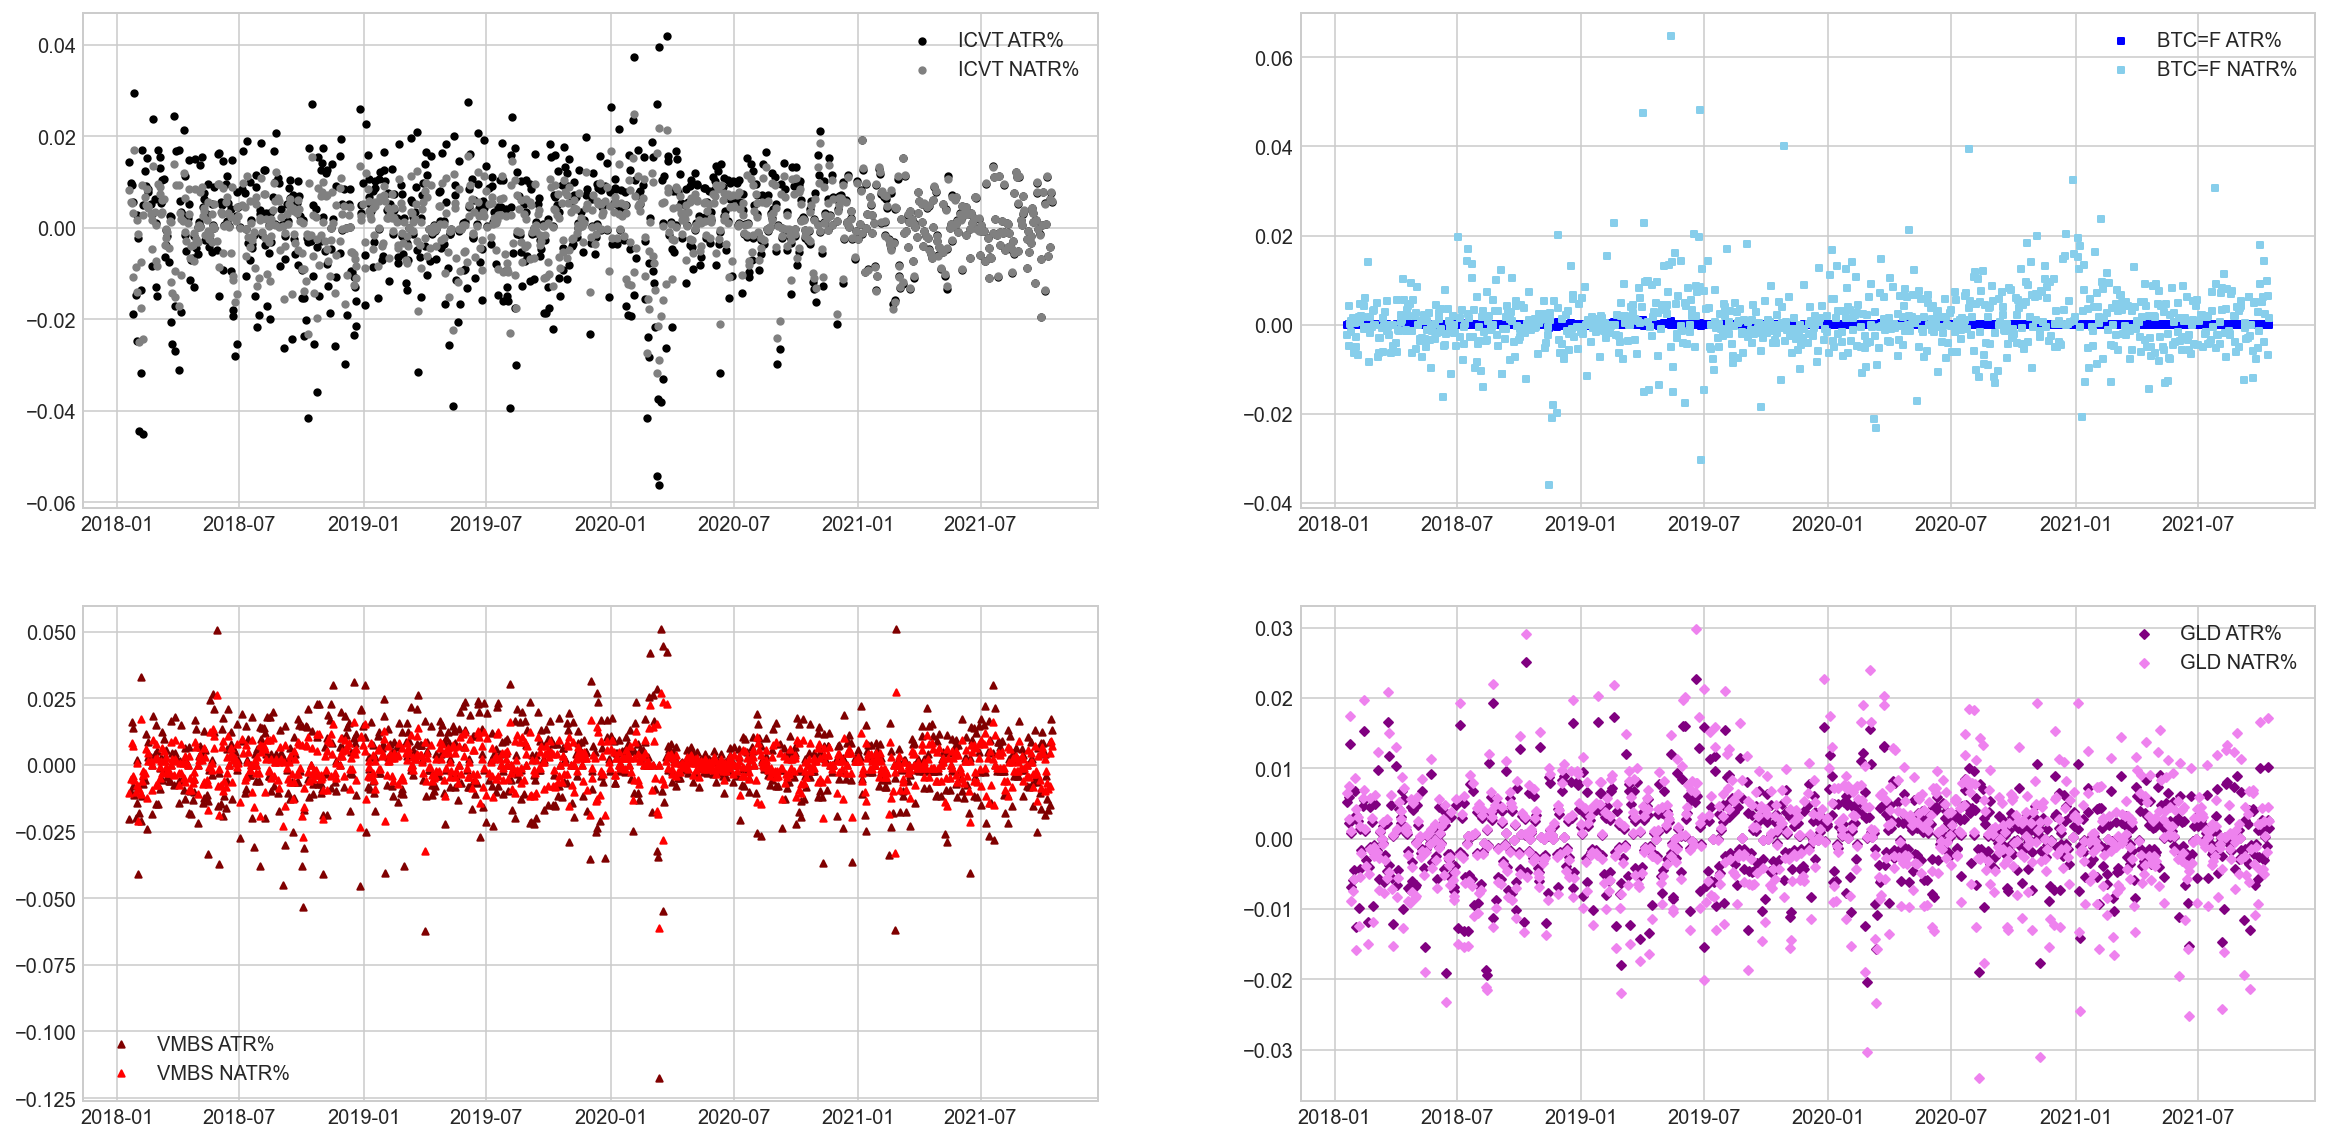

In [11]:
# Plotting the ATR and NATR sensitivity
for n, ticker in enumerate(tickers):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
    axes[0,0].scatter(elasticity_df.Date, elasticity_df[ticker+'_ATR%'], label=str(ticker+' ATR%'), color='black', s=10)
    axes[0,0].scatter(elasticity_df.Date, elasticity_df[ticker+'_NATR%'], label=str(ticker+' NATR%'), color='grey', s=10)
    axes[0,0].legend()
    axes[0,1].scatter(elasticity_df.Date, elasticity_df[tickers[n+1]+'_ATR%'], label=str(tickers[n+1]+' ATR%'), color='blue', marker='s', s=10)
    axes[0,1].scatter(elasticity_df.Date, elasticity_df[tickers[n+1]+'_NATR%'], label=str(tickers[n+1]+' NATR%'), color='skyblue', marker='s', s=10)
    axes[0,1].legend()
    axes[1,0].scatter(elasticity_df.Date, elasticity_df[tickers[n+2]+'_ATR%'], label=str(tickers[n+2]+' ATR%'), color='maroon', marker='^', s=10)
    axes[1,0].scatter(elasticity_df.Date, elasticity_df[tickers[n+2]+'_NATR%'], label=str(tickers[n+2]+' NATR%'), color='red', marker='^', s=10)
    axes[1,0].legend()
    axes[1,1].scatter(elasticity_df.Date, elasticity_df[tickers[n+3]+'_ATR%'], label=str(tickers[n+3]+' ATR%'), color='purple', marker='D', s=10)
    axes[1,1].scatter(elasticity_df.Date, elasticity_df[tickers[n+3]+'_NATR%'], label=str(tickers[n+3]+' NATR%'), color='violet', marker='D', s=10)
    axes[1,1].legend()
    break

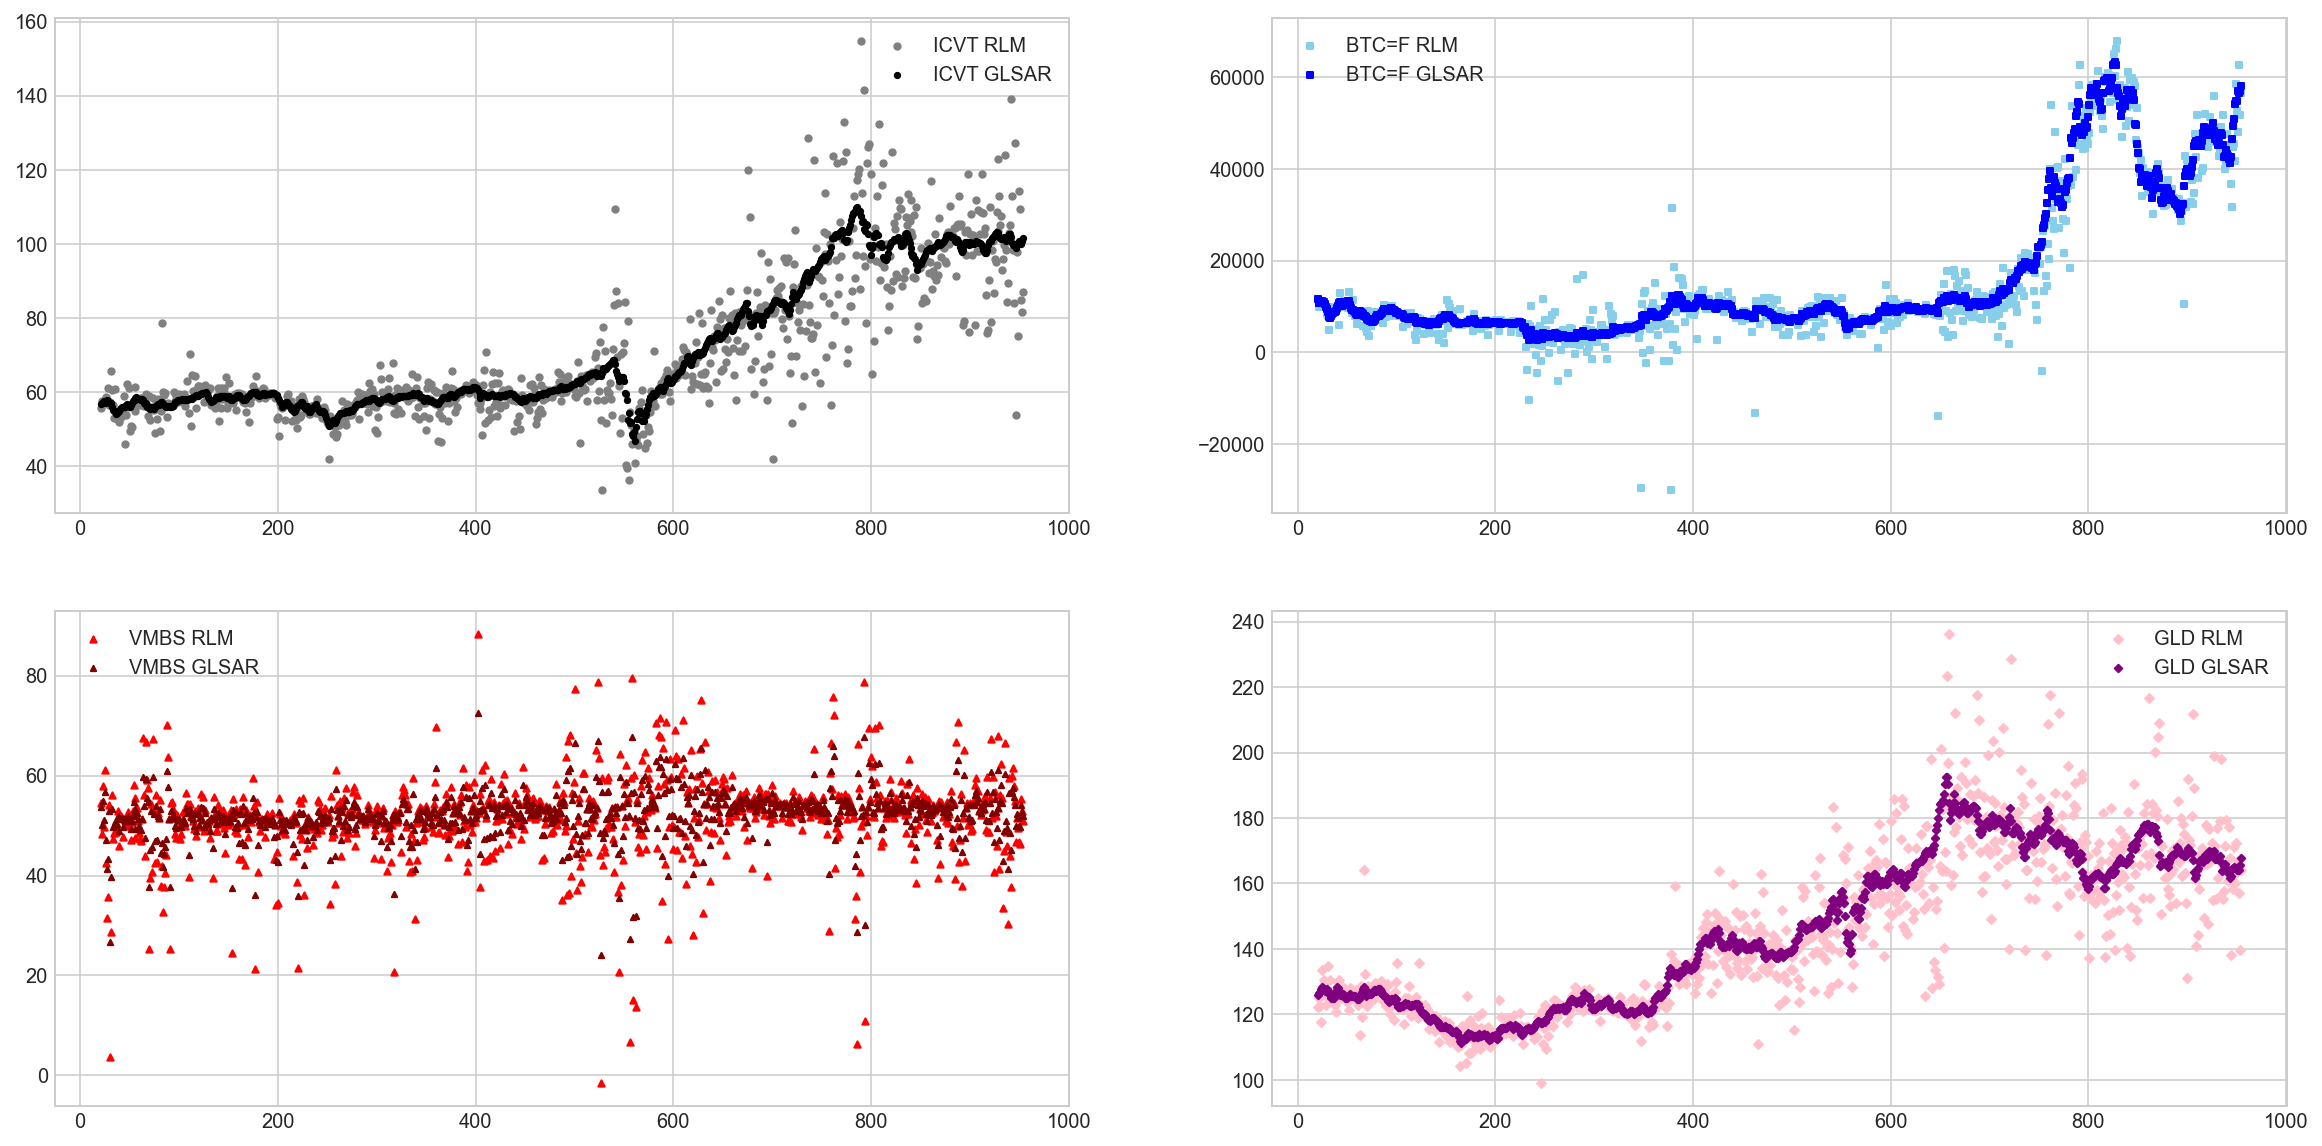

In [12]:
'''
Performing two different kinds of regressions on the data.
    - Generalized Least Squares with AR Covariance
    - Robust Linear Regression
'''

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
for n, ticker in enumerate(tickers):
    #GLSAR
    for i in range(1, 11):
        model = sm.GLSAR(elasticity_df[ticker+'_Close'], 
                         elasticity_df[[ticker+'_Elasticity', ticker+'_Sensitivity', ticker+'_ATR%', ticker+'_NATR%']], rho=i)
        results = model.fit()
        rho, sigma = sm.regression.yule_walker(results.resid, order=model.order)
        model = sm.GLSAR(elasticity_df[ticker+'_Close'], 
                         elasticity_df[[ticker+'_Elasticity', ticker+'_Sensitivity', ticker+'_ATR%', ticker+'_NATR%']], rho)
        results = model.fit()
    results.summary()

    #Robust Linear Model
    rlm_model = sm.RLM(elasticity_df[ticker+'_Close'], 
                       elasticity_df[[ticker+'_Elasticity', ticker+'_Sensitivity', ticker+'_ATR%', ticker+'_NATR%']], M=sm.robust.norms.HuberT())
    rlm_results = rlm_model.fit()
    rlm_results.summary()
    
    # Plotting the residuals
    if n==0:
        ax[0,0].scatter(rlm_results.resid.index, rlm_results.resid, label=str(ticker+' RLM'), color='grey', s=10)
        ax[0,0].scatter(results.resid.index, results.resid, label=str(ticker+' GLSAR'), color='black', s=7)
        ax[0,0].legend()
    if n==1:
        ax[0,1].scatter(rlm_results.resid.index, rlm_results.resid, label=str(ticker+' RLM'), color='skyblue', marker='s', s=10)
        ax[0,1].scatter(results.resid.index, results.resid, label=str(ticker+' GLSAR'), color='blue', marker='s', s=7)
        ax[0,1].legend()
    if n==2:
        ax[1,0].scatter(rlm_results.resid.index, rlm_results.resid, label=str(ticker+' RLM'), color='red', marker='^', s=10)
        ax[1,0].scatter(results.resid.index, results.resid, label=str(ticker+' GLSAR'), color='maroon', marker='^', s=7)
        ax[1,0].legend()
    if n==3:
        ax[1,1].scatter(rlm_results.resid.index, rlm_results.resid, label=str(ticker+' RLM'), color='pink', marker='D', s=10)
        ax[1,1].scatter(results.resid.index, results.resid, label=str(ticker+' GLSAR'), color='purple', marker='D', s=7)
        ax[1,1].legend()

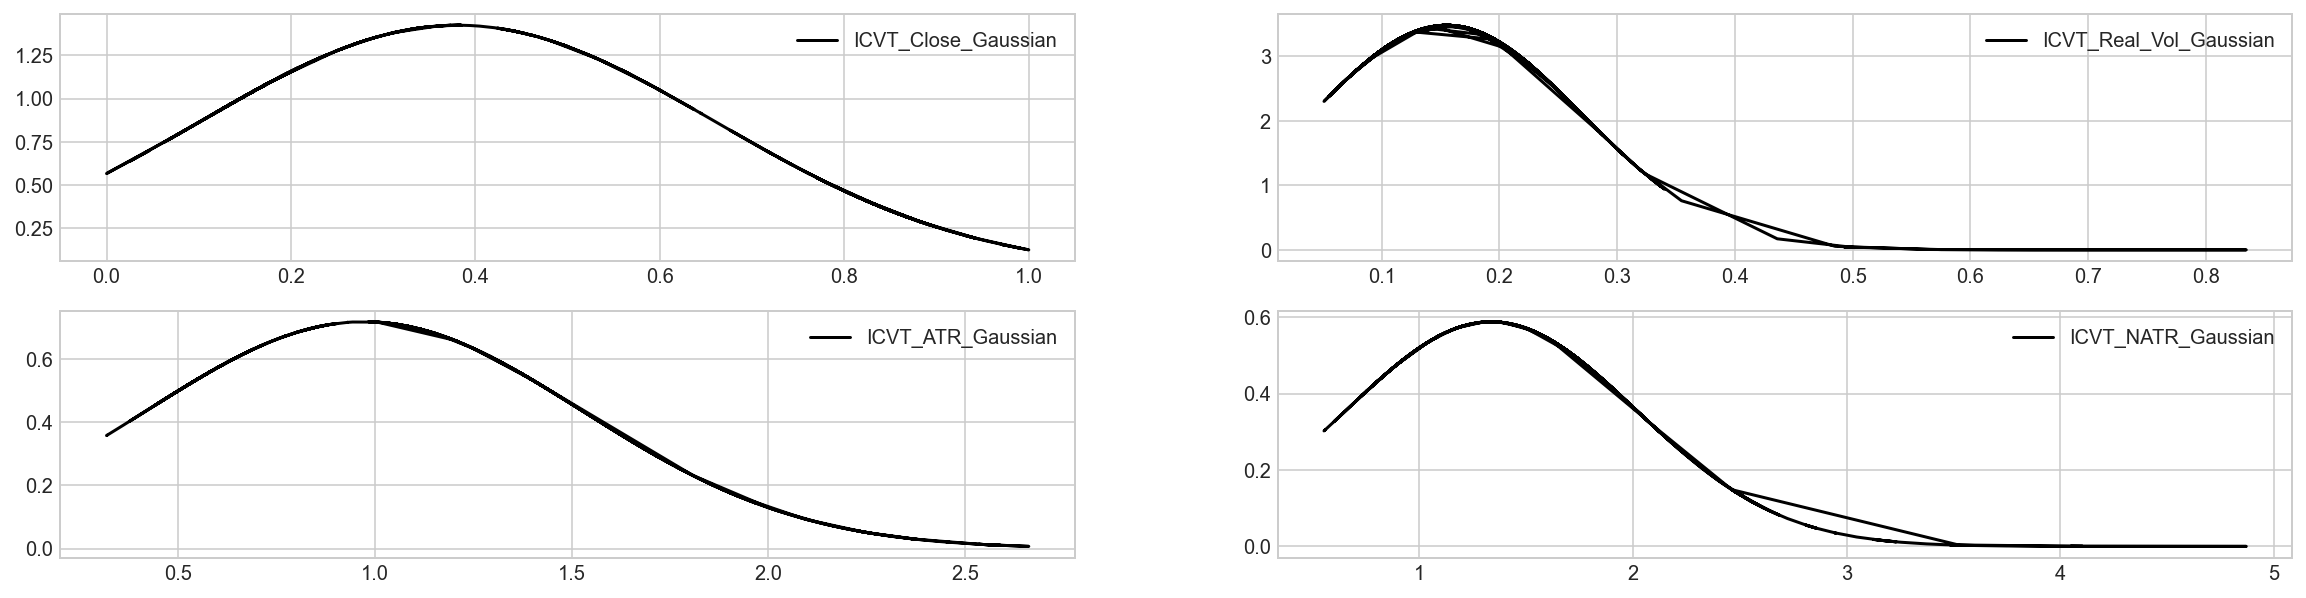

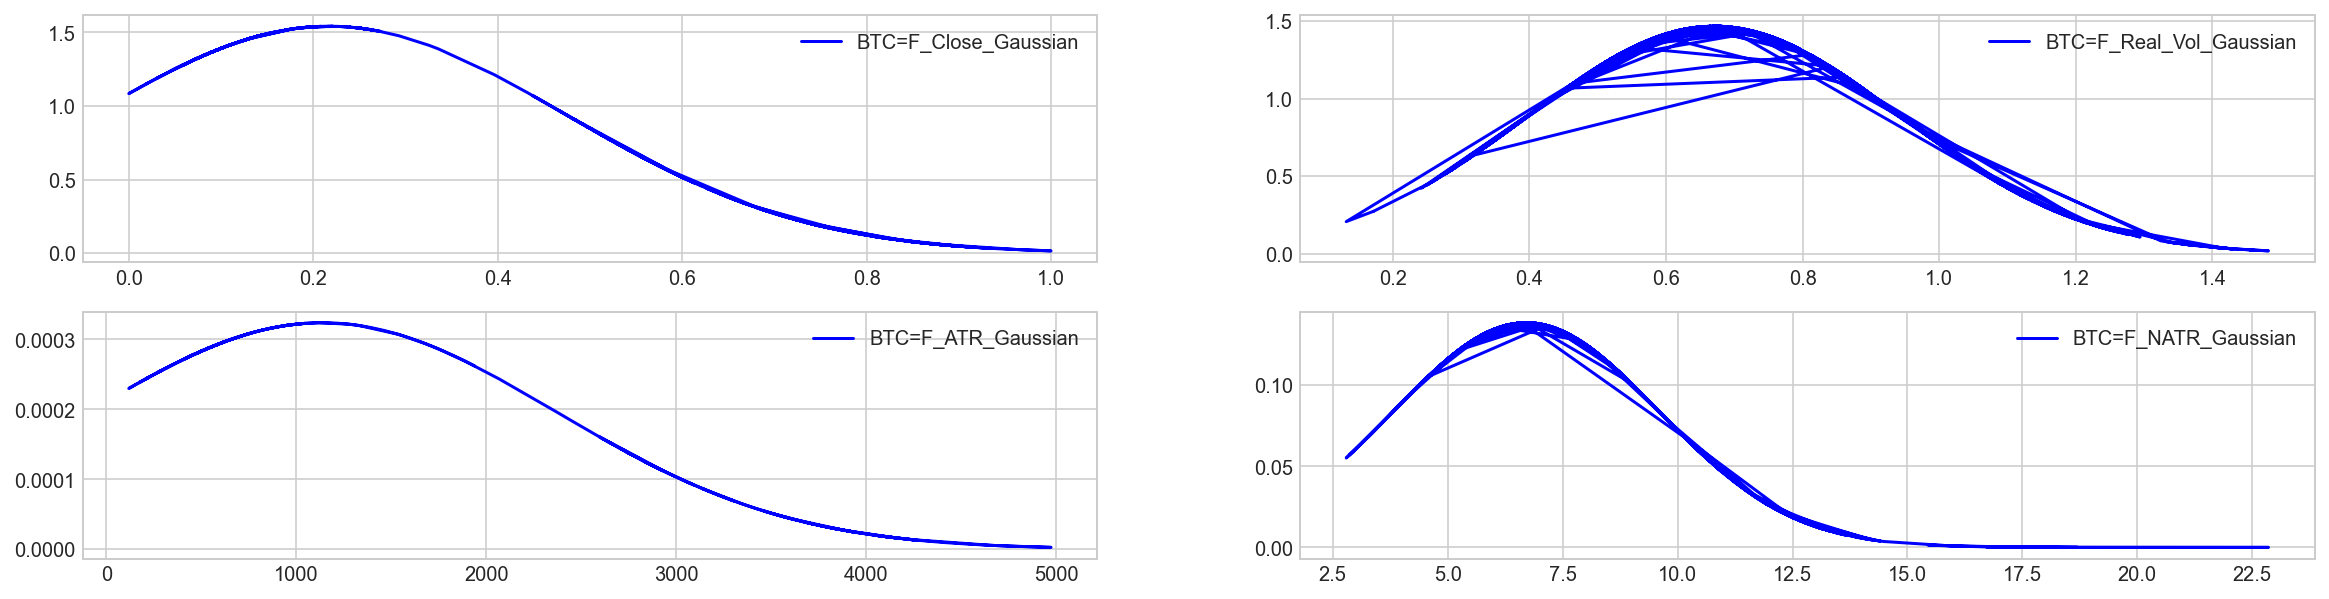

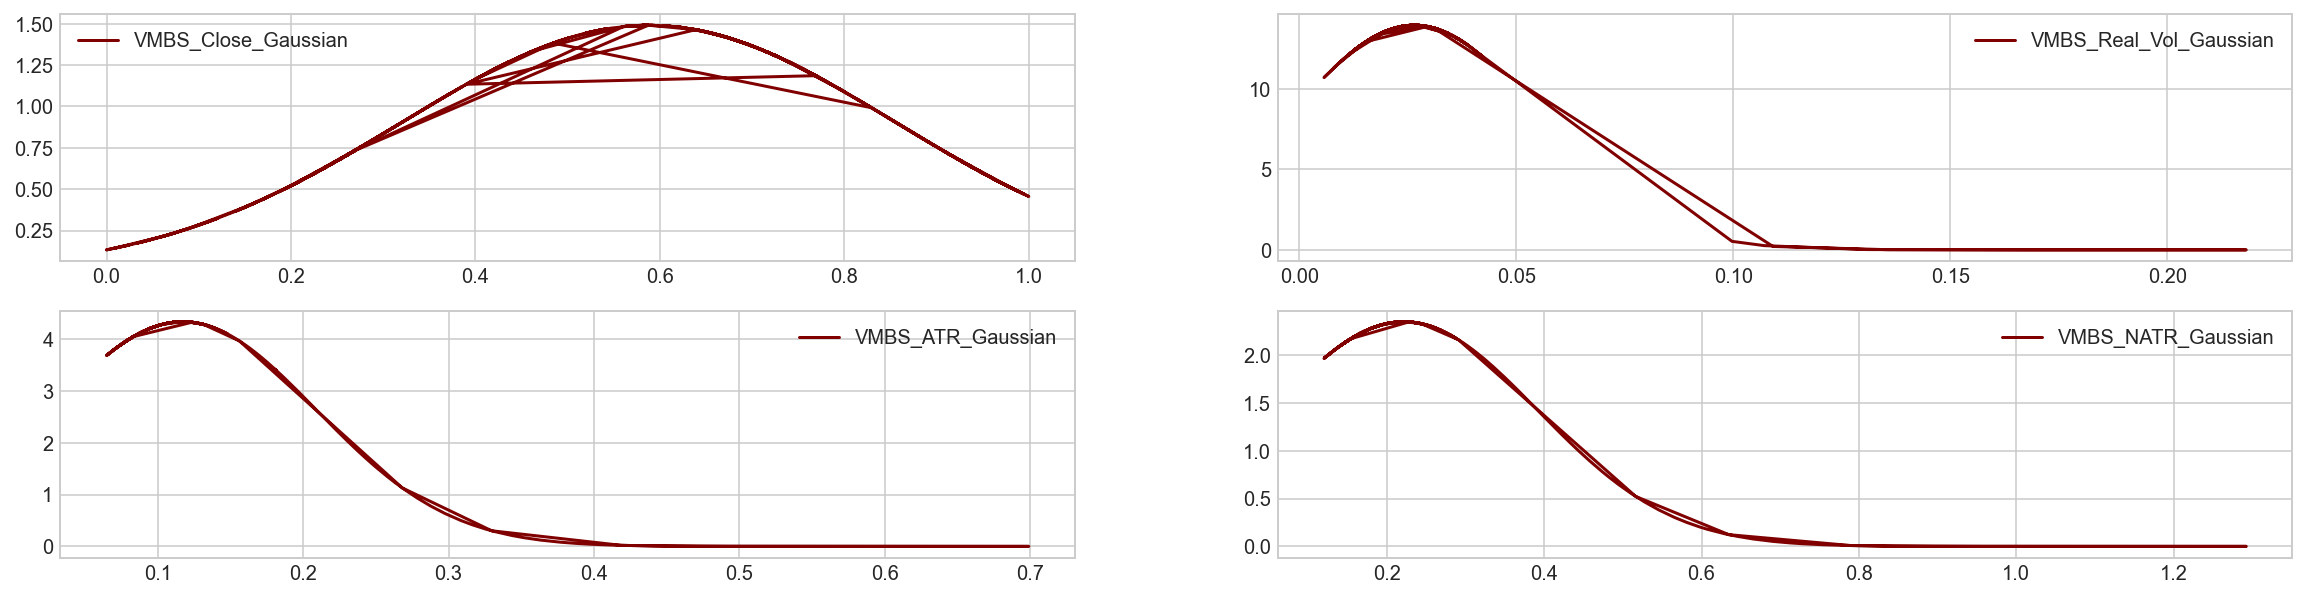

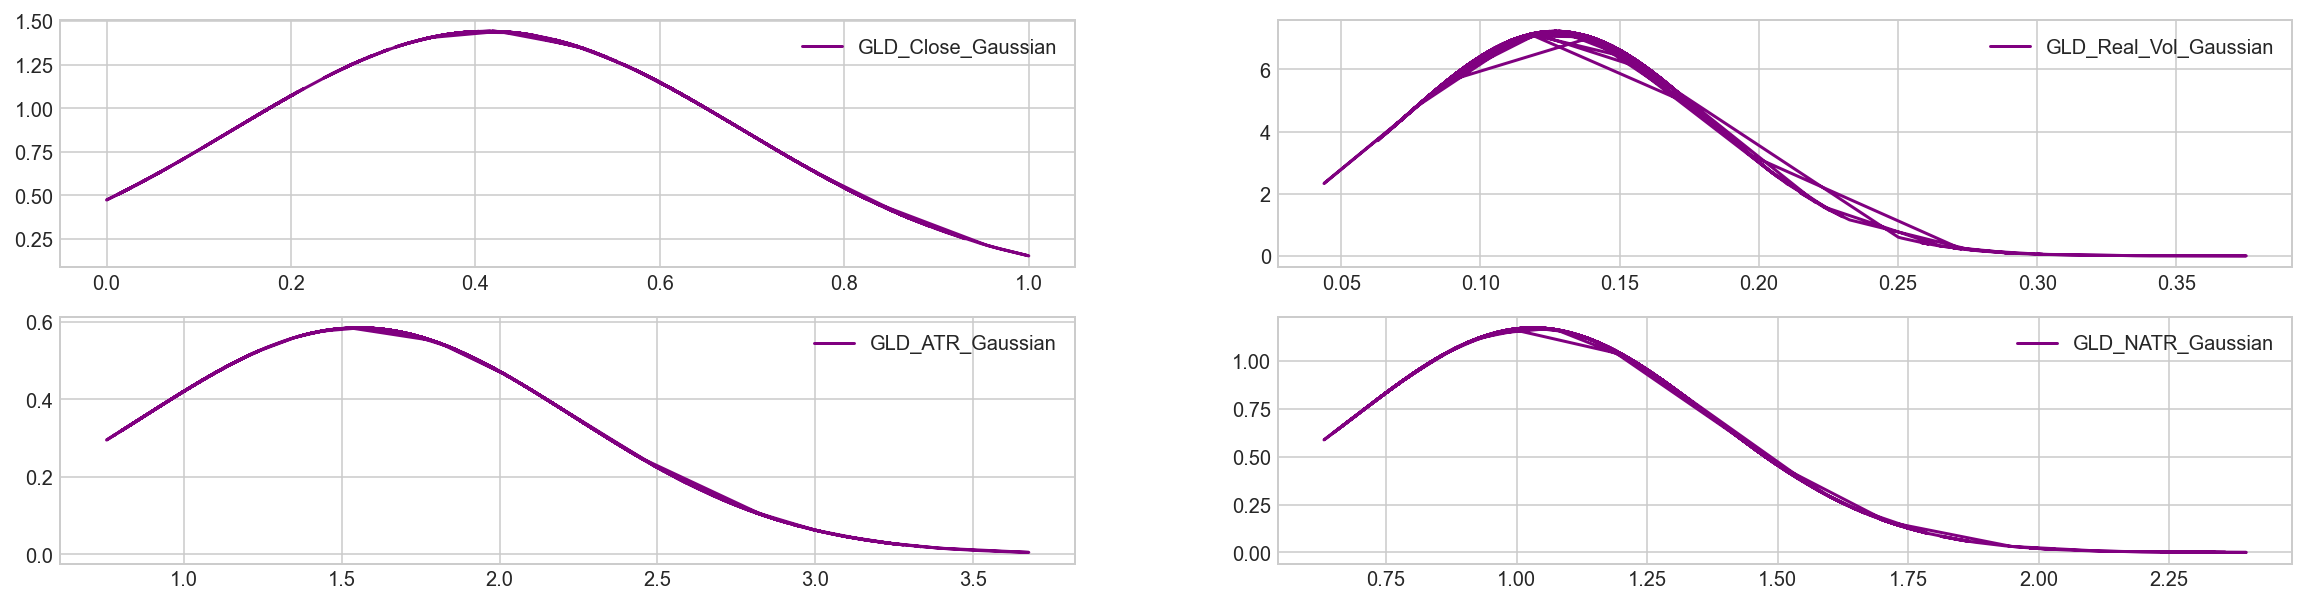

In [13]:
#Calculating a Gaussian Distribution and Probability Density Function

#mean value
def average(data):
    return np.sum(data)/len(data)
#standard deviation
def sigma(data,avg):
    sigma_squ=np.sum(np.power((data-avg),2))/len(data)
    return np.power(sigma_squ,0.5)
def prob(data,avg,sig):
    #print(data)
    sqrt_2pi=np.power(2*np.pi,0.5)
    coef=1/(sqrt_2pi*sig)
    powercoef=-1/(2*np.power(sig,2))
    mypow=powercoef*(np.power((data-avg),2))
    return coef*(np.exp(mypow))

for n, ticker in enumerate(tickers):
    columns = ['_Close', '_Real_Vol', '_ATR', '_NATR']
    fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,5))
    colors = ['black','blue','maroon','purple']
    for m, column in enumerate(columns):
        y = data[[ticker+column]]
        ave = average(y)
        sig = sigma(y, ave)
        p = prob(y, ave, sig)
        # Plotting the PDF
        if m==0:
            ax[0,0].plot(y,p,label=str(ticker+column+'_Gaussian'),color=colors[n])
            ax[0,0].legend()
        elif m==1:
            ax[0,1].plot(y,p,label=str(ticker+column+'_Gaussian'),color=colors[n])
            ax[0,1].legend()
        elif m==2:
            ax[1,0].plot(y,p,label=str(ticker+column+'_Gaussian'),color=colors[n])
            ax[1,0].legend()
        elif m==3:
            ax[1,1].plot(y,p,label=str(ticker+column+'_Gaussian'),color=colors[n])
            ax[1,1].legend()

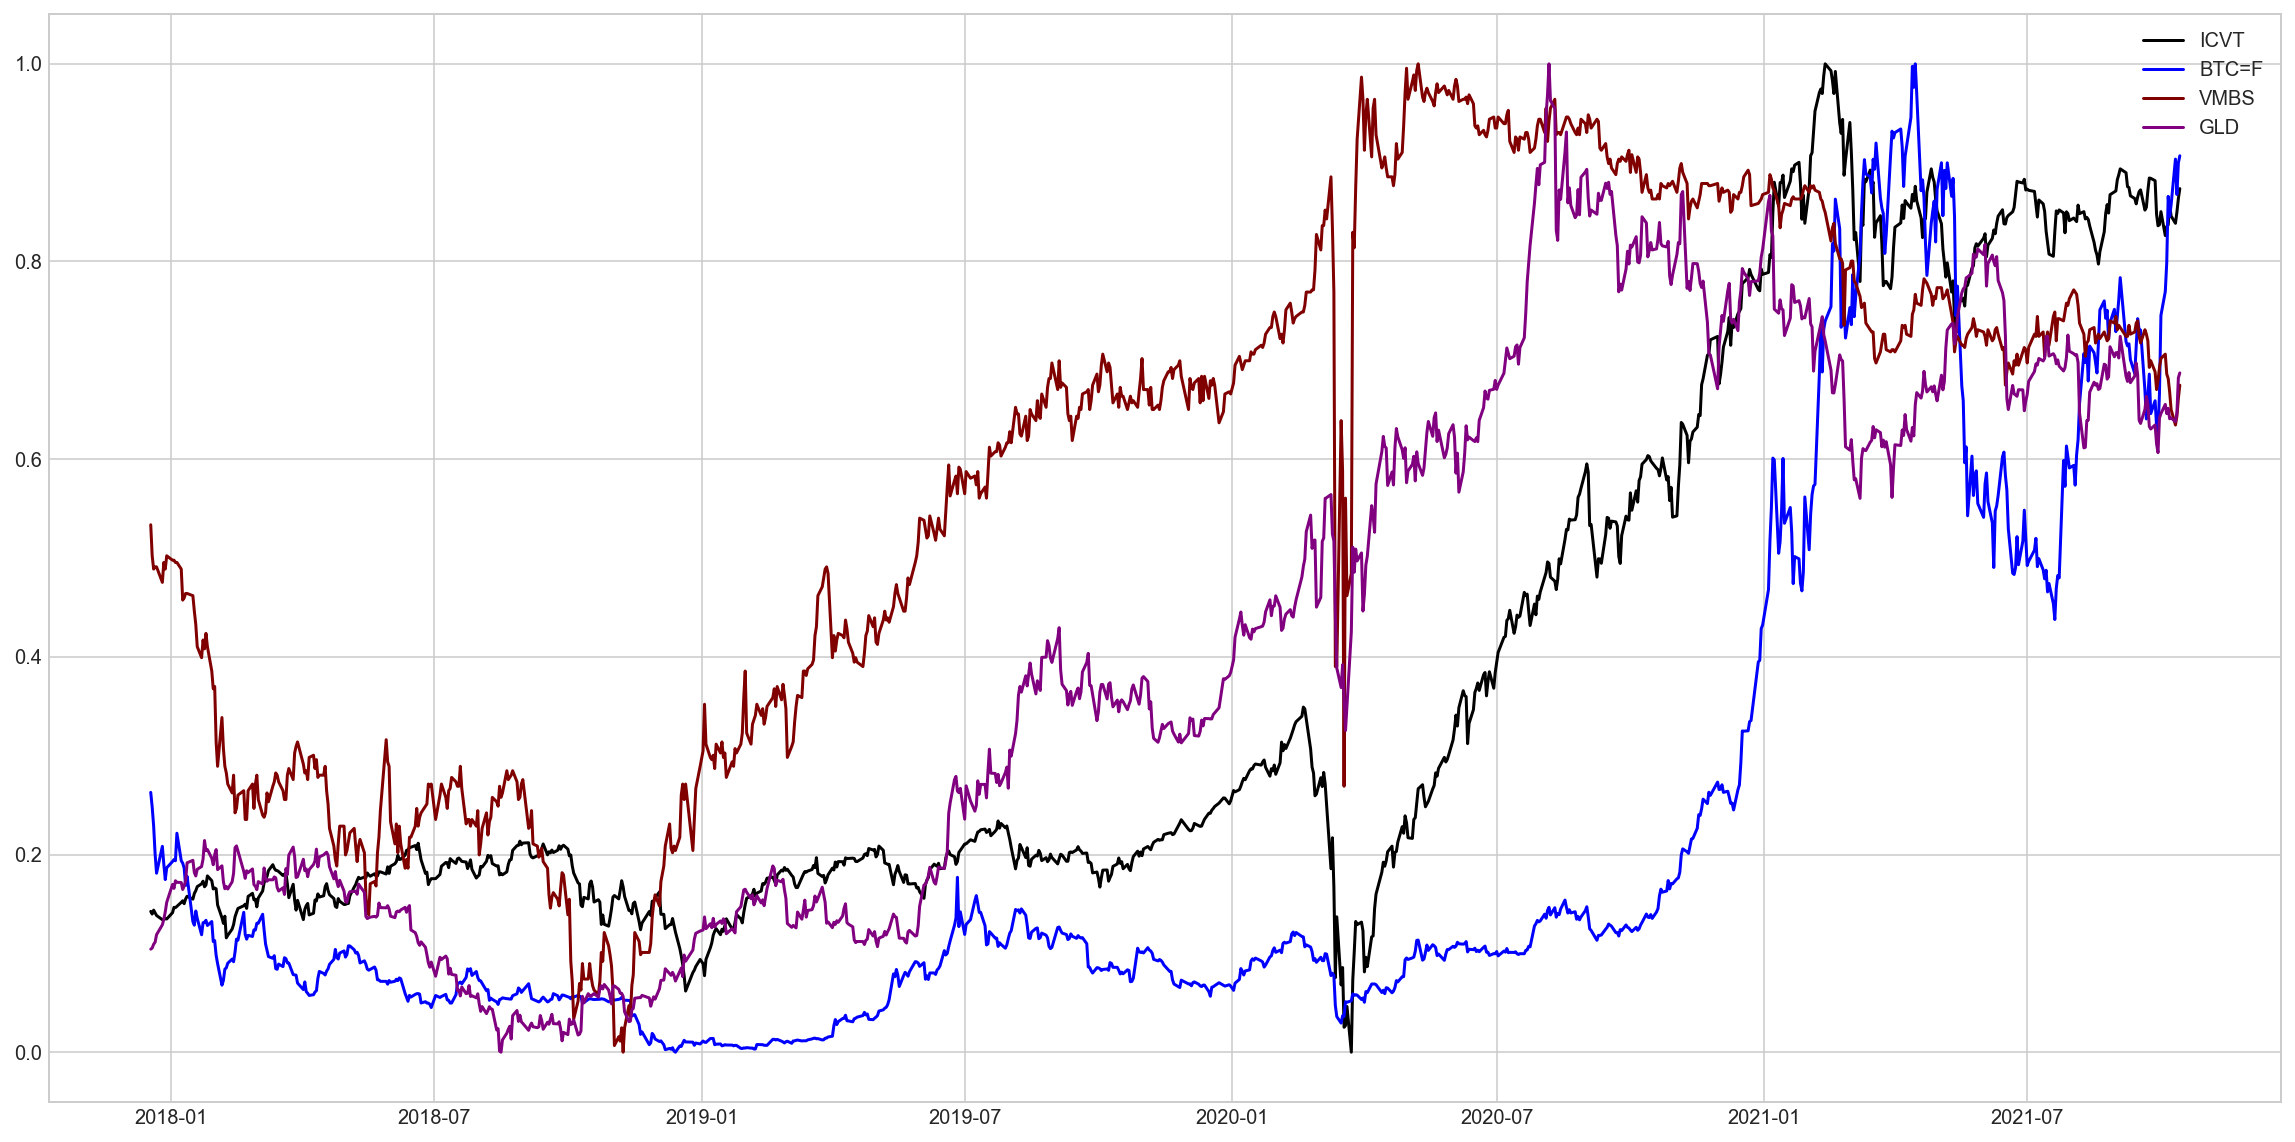

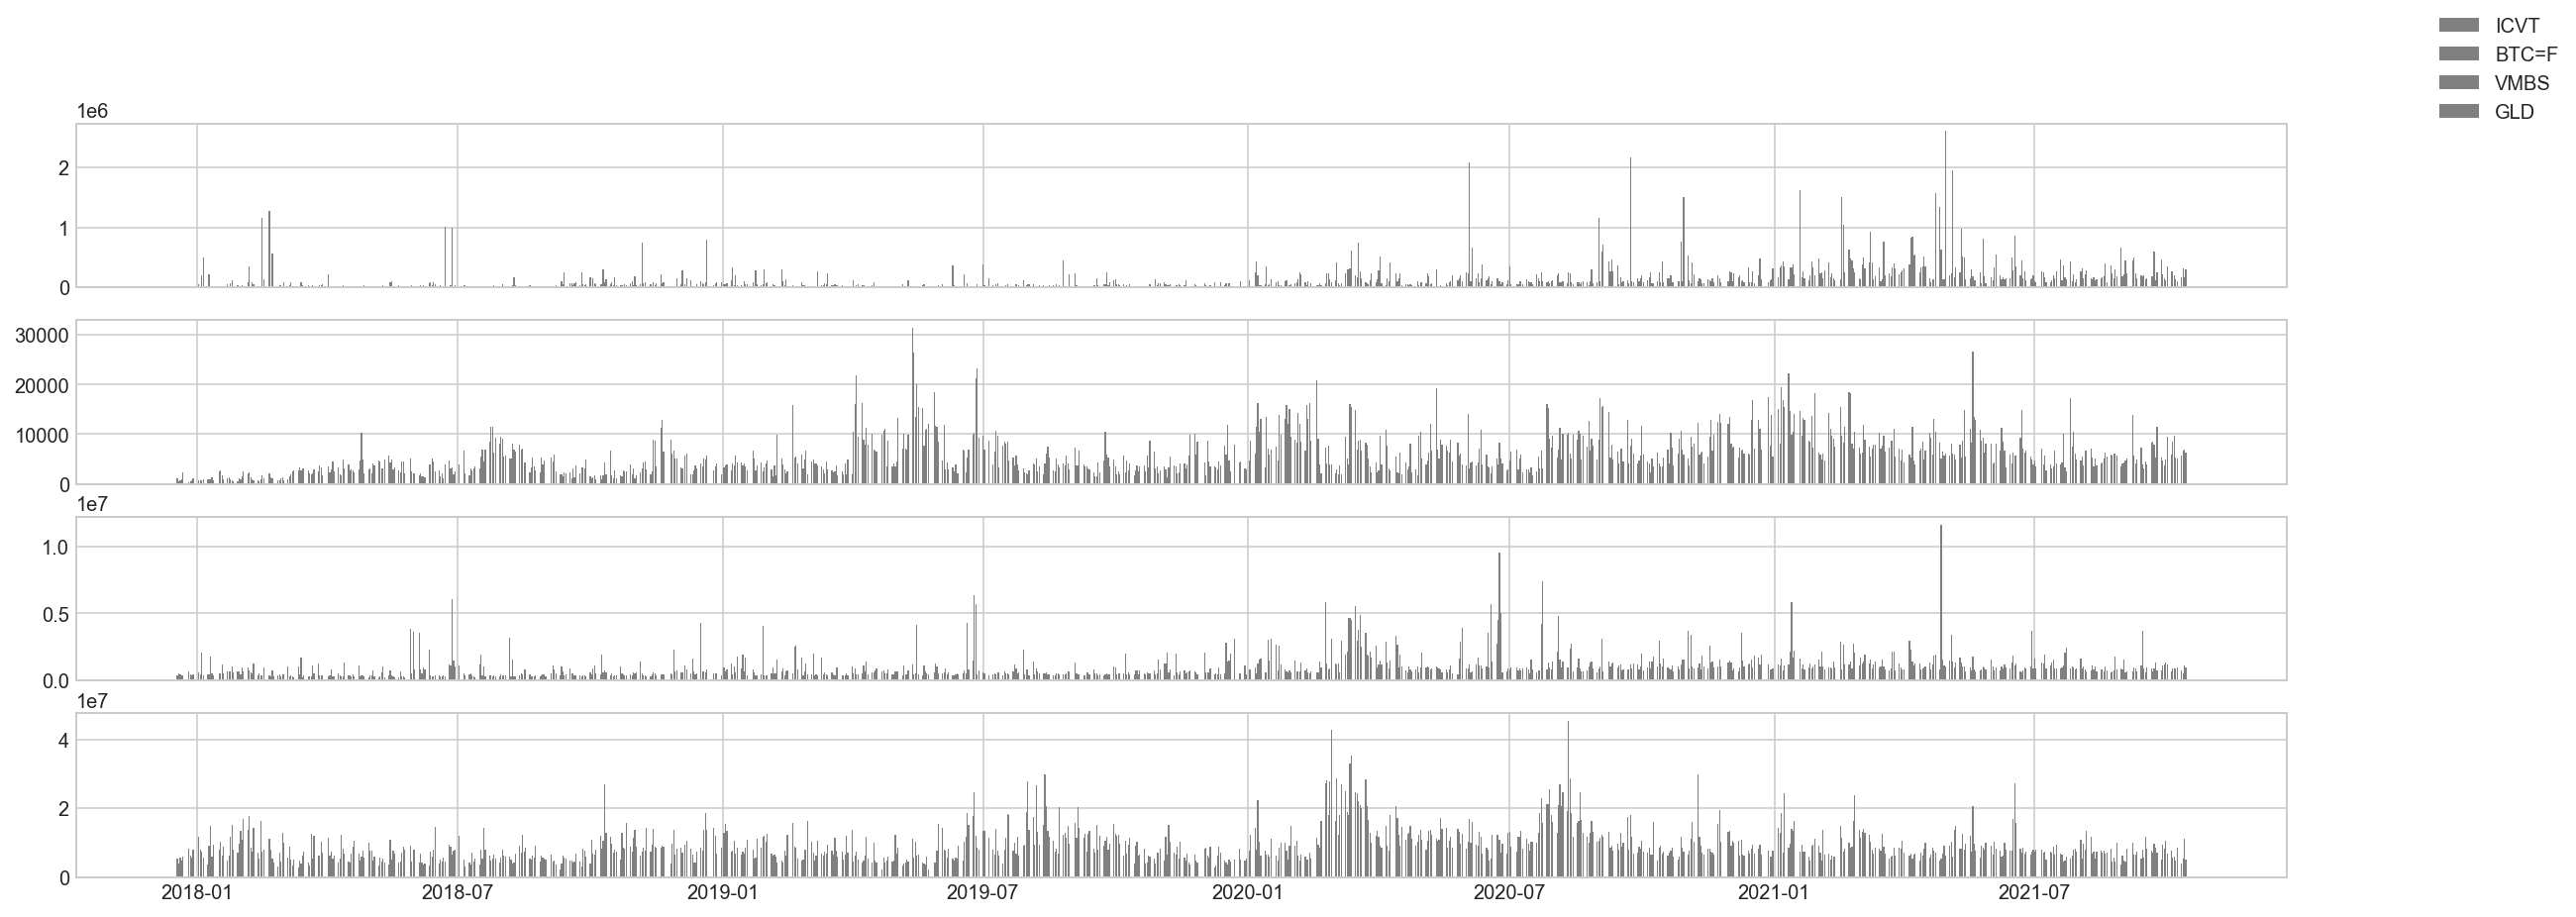

In [14]:
# Plotting the minmaxed close prices (to allow simultaneous viewing)
for n, ticker in enumerate(tickers):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(data.Date, data[ticker+'_Close'], label=str(ticker), color='black')
    ax.plot(data.Date, data[tickers[n+1]+'_Close'], label=str(tickers[n+1]), color='blue')
    ax.plot(data.Date, data[tickers[n+2]+'_Close'], label=str(tickers[n+2]), color='maroon')
    ax.plot(data.Date, data[tickers[n+3]+'_Close'], label=str(tickers[n+3]), color='purple')
    ax.legend()

    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20, 7), sharex=True)
    ax[0, ].bar(data.Date, data[ticker+'_Volume'], label=str(ticker), color='grey')
    ax[1, ].bar(data.Date, data[tickers[n+1]+'_Volume'], label=str(tickers[n+1]), color='grey')
    ax[2, ].bar(data.Date, data[tickers[n+2]+'_Volume'], label=str(tickers[n+2]), color='grey')
    ax[3, ].bar(data.Date, data[tickers[n+3]+'_Volume'], label=str(tickers[n+3]), color='grey')
    fig.legend()
    break